In [1]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import default_style
# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

In [2]:
DATA_FOLDER = 'dataset'
IMAGE_FOLDER = 'images'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [4]:
TARGET_COLUMN = 'vocal_channel'

In [5]:
values = df[TARGET_COLUMN].unique().tolist()
values

['speech', 'song']

In [6]:
one_hot = pd.get_dummies(df[TARGET_COLUMN])
df = df.join(one_hot)
df = df.drop([TARGET_COLUMN], axis=1)

In [7]:
def plot_percentage(data, columns):
    ones_percentage = [data[col].mean() * 100 for col in columns]

    plt.figure(figsize=default_style.FULLSIZE_FIGURE)
    plt.bar(columns, ones_percentage)
    plt.xlabel('Columns')
    plt.ylabel('Percentage of ones')
    plt.title('Percentage of ones in each column')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.yticks(range(0, 101, 10))  # increments of 10 along the y-axis
    plt.show()

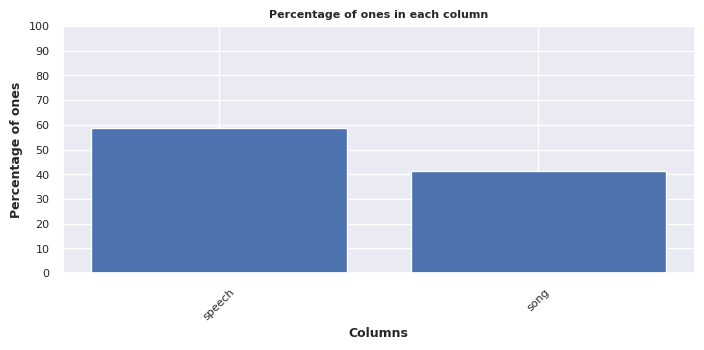

In [8]:
plot_percentage(df, values)

## Visualize the target class

In [9]:
TARGET_CLASS = 'song'

In [10]:
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler

def isomap_by_class(data, values_list, value):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    isomap = Isomap(n_components=2)
    embedding = isomap.fit_transform(X_scaled)

    plt.figure(figsize=default_style.FULLSIZE_FIGURE)
    plt.scatter(embedding[:, 0], embedding[:, 1], s=15,c=data[value], cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {value} attribute using Isomap')
    plt.show()

In [11]:
from sklearn.decomposition import PCA

def pca_by_class(data, values_list, value):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    pca = PCA(n_components=2)
    embedding = pca.fit_transform(X_scaled)

    plt.figure(figsize=default_style.FULLSIZE_FIGURE)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=data[value],s=15, cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {value} attribute using PCA')
    plt.show()

In [12]:
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

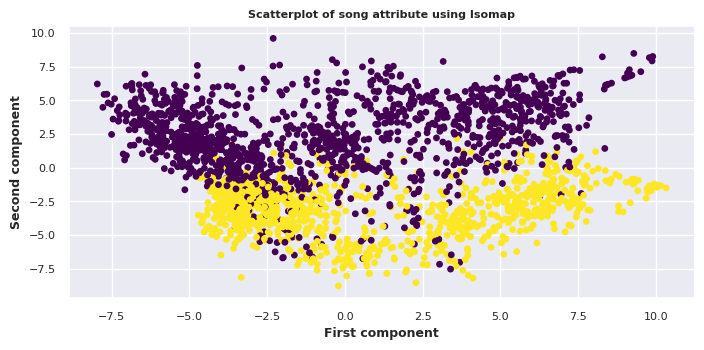

In [13]:
isomap_by_class(df[numerical_attr_list], values, TARGET_CLASS)

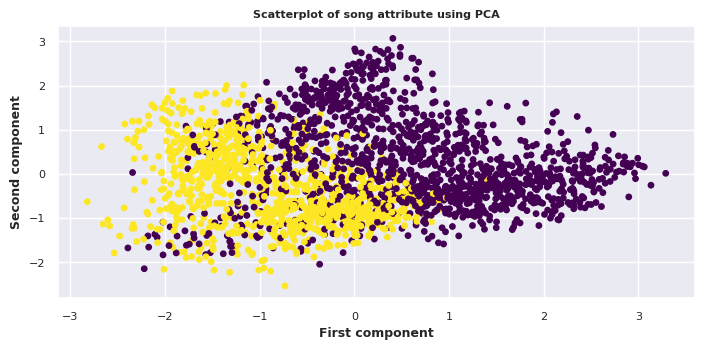

In [14]:
pca_by_class(df[numerical_attr_list], values, TARGET_CLASS)

## Dataset imbalance

In [15]:
from sklearn.model_selection import train_test_split

split_index = df.index[df['actor'] == 'actor_19'][0]

df_train = df[:split_index]
df_test = df[split_index:]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train, df_valid = train_test_split(df_train, test_size = 0.2, random_state = 100)




In [16]:
target_class_count_t = df_train[TARGET_CLASS].sum()
target_class_count_v = df_valid[TARGET_CLASS].sum()
other_class_count_t = df_train.shape[0] - target_class_count_t
other_class_count_v = df_valid.shape[0] - target_class_count_v
eight_percent_t = int(other_class_count_t * 8 / 100)
eight_percent_v = int(other_class_count_v * 8 / 100)

# target class is 8% the size of the other one
rows_to_keep_t = np.random.choice(df_train[df_train[TARGET_CLASS] == 1].index, eight_percent_t, replace=False)
rows_to_keep_v = np.random.choice(df_valid[df_valid[TARGET_CLASS] == 1].index, eight_percent_v, replace=False)
df_train = df_train[(df_train[TARGET_CLASS] == 1 & df_train.index.isin(rows_to_keep_t)) | (df_train[TARGET_CLASS] == 0)]
df_valid = df_valid[(df_valid[TARGET_CLASS] == 1 & df_valid.index.isin(rows_to_keep_v)) | (df_valid[TARGET_CLASS] == 0)]

df_valid = df_valid.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

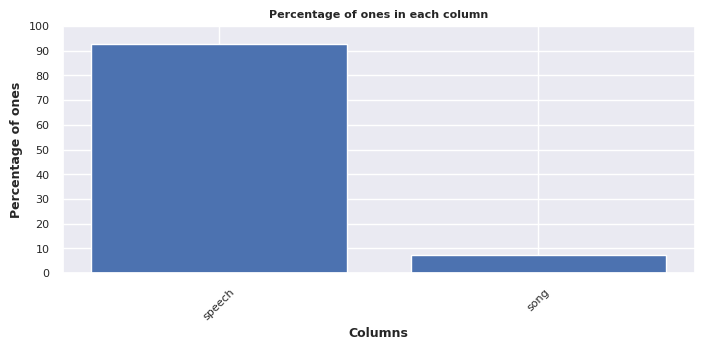

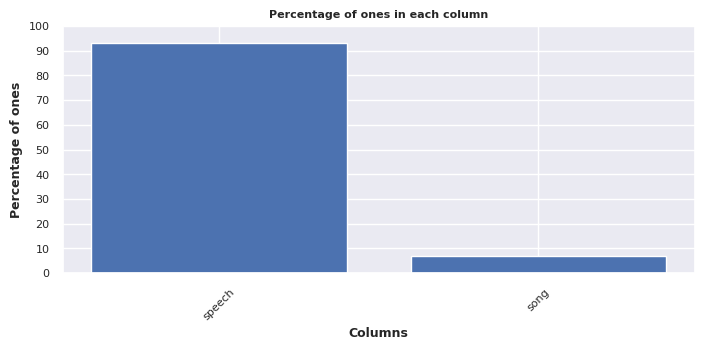

In [17]:
plot_percentage(df_train, values)
plot_percentage(df_valid, values)

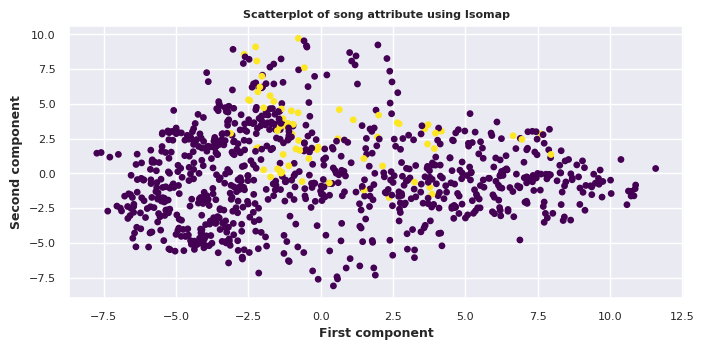

In [18]:
isomap_by_class(df_train[numerical_attr_list], values, TARGET_CLASS)

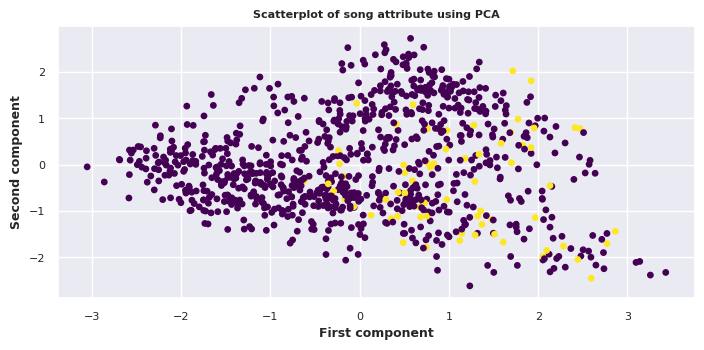

In [19]:
pca_by_class(df_train[numerical_attr_list], values, TARGET_CLASS)

# Dataset preparation

In [20]:
target_train = df_train[TARGET_CLASS]
target_valid = df_valid[TARGET_CLASS]
target_test = df_test[TARGET_CLASS]

display(df_train.shape, df_valid.shape, df_test.shape)

(914, 251)

(241, 251)

(617, 251)

In [21]:
excluded_prefixes = ['zc']
columns_to_keep = []

for column in df[numerical_attr_list].drop(values, axis=1).columns:
    if not column.startswith(tuple(excluded_prefixes)) and column != TARGET_COLUMN:
        columns_to_keep.append(column)

# selected features without target
columns_to_keep

['frame_count',
 'sum',
 'mean',
 'std',
 'min',
 'max',
 'q01',
 'q05',
 'q25',
 'q75',
 'q95',
 'q99',
 'kur',
 'skew',
 'lag1_q25',
 'lag1_q75',
 'lag1_skew',
 'mfcc_sum',
 'mfcc_mean',
 'mfcc_std',
 'mfcc_min',
 'mfcc_max',
 'mfcc_q01',
 'mfcc_q05',
 'mfcc_q25',
 'mfcc_q50',
 'mfcc_q75',
 'mfcc_q95',
 'mfcc_q99',
 'mfcc_kur',
 'mfcc_skew',
 'sc_sum',
 'sc_mean',
 'sc_std',
 'sc_min',
 'sc_max',
 'sc_q01',
 'sc_q05',
 'sc_q25',
 'sc_q50',
 'sc_q75',
 'sc_q95',
 'sc_q99',
 'sc_kur',
 'sc_skew',
 'stft_sum',
 'stft_mean',
 'stft_std',
 'stft_min',
 'stft_q01',
 'stft_q05',
 'stft_q25',
 'stft_q50',
 'stft_q75',
 'stft_kur',
 'stft_skew',
 'length_w1',
 'sum_w1',
 'std_w1',
 'q05_w1',
 'kur_w1',
 'skew_w1',
 'lag1_sum_w1',
 'lag1_max_w1',
 'lag1_q95_w1',
 'lag1_kur_w1',
 'lag1_skew_w1',
 'mfcc_sum_w1',
 'mfcc_mean_w1',
 'mfcc_std_w1',
 'mfcc_min_w1',
 'mfcc_max_w1',
 'mfcc_q05_w1',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'mfcc_q75_w1',
 'mfcc_q95_w1',
 'mfcc_q99_w1',
 'mfcc_kur_w1',
 'mfcc_sk

In [22]:
df_train = df_train.drop(df_train.columns.difference(columns_to_keep), axis=1)
df_valid = df_valid.drop(df_valid.columns.difference(columns_to_keep), axis=1)
df_test = df_test.drop(df_test.columns.difference(columns_to_keep), axis=1)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [23]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train)
X_valid = scaler.fit_transform(df_valid)
X_test = scaler.fit_transform(df_test)

y_train = target_train.to_numpy()
y_valid = target_valid.to_numpy()
y_test = target_test.to_numpy()

# Undersampling
## CNN

In [24]:
from collections import Counter
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42, n_jobs=-1)

X_res_t, y_res_t = cnn.fit_resample(X_train, y_train)
X_res_v, y_res_v = cnn.fit_resample(X_valid, y_valid)

print(f'Starting dataset shape: train {Counter(y_train)}   validation {Counter(y_valid)}')
print(f'Resampled dataset shape: train {Counter(y_res_t)}   validation {Counter(y_res_v)}')

Starting dataset shape: train Counter({False: 847, True: 67})   validation Counter({False: 224, True: 17})
Resampled dataset shape: train Counter({False: 67, True: 67})   validation Counter({False: 26, True: 17})


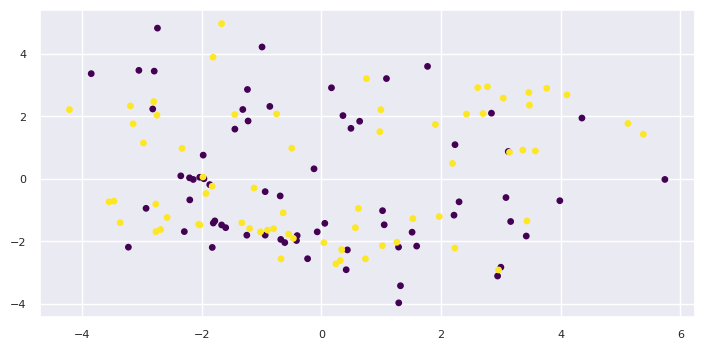

In [25]:
isomap = Isomap(n_components=2, n_neighbors=10)
embedding = isomap.fit_transform(X_res_t)

plt.figure(figsize=default_style.FULLSIZE_FIGURE)
plt.scatter(embedding[:, 0], embedding[:, 1], s=15, c=y_res_t, cmap='viridis')
plt.show()

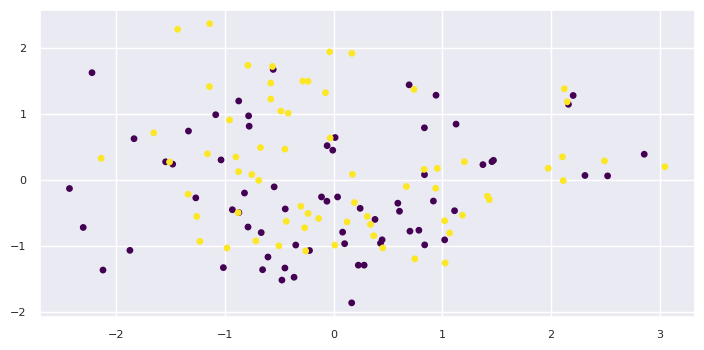

In [26]:
pca = PCA(n_components=2)
embedding = pca.fit_transform(X_res_t)

plt.figure(figsize=default_style.FULLSIZE_FIGURE)
plt.scatter(embedding[:, 0], embedding[:, 1], s=15, c=y_res_t, cmap='viridis')
plt.show()

# Logistic Regression

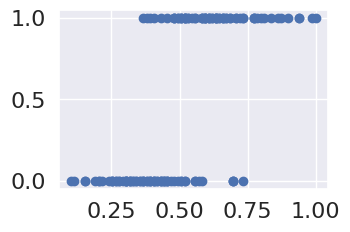

In [27]:
plt.scatter(X_res_t.T[0], y_res_t)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])
    

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_res_t, y_res_t)
    y_pred = logr.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError, TypeError))

[I 2023-06-20 17:10:24,195] A new study created in memory with name: no-name-13a8ae30-9af0-4c23-b422-270ea19cda34
[W 2023-06-20 17:10:24,210] Trial 1 failed with parameters: {'penalty': 'elasticnet', 'C': 1.3217045488896177, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_l

[W 2023-06-20 17:10:24,668] Trial 10 failed with parameters: {'penalty': 'elasticnet', 'C': 8.633027763124998, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none'

[W 2023-06-20 17:10:25,463] Trial 21 failed with value None.
[I 2023-06-20 17:10:25,464] Trial 20 finished with value: 0.9534883720930233 and parameters: {'penalty': 'l2', 'C': 0.16840454979786743, 'solver': 'sag'}. Best is trial 2 with value: 0.9534883720930233.
[W 2023-06-20 17:10:25,624] Trial 24 failed with parameters: {'penalty': 'elasticnet', 'C': 6.44561970758815, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verb

[W 2023-06-20 17:10:25,908] Trial 28 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-06-20 17:10:25,945] Trial 25 finished with value: 0.9534883720930233 and parameters: {'penalty': 'l1', 'C': 6.459352902985874, 'solver': 'saga'}. Best is trial 2 with value: 0.9534883720930233.
[W 2023-06-20 17:10:25,954] Trial 29 failed with parameters: {'penalty': 'elasticnet', 'C': 3.950655139313363, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.

[W 2023-06-20 17:10:26,122] Trial 31 failed with parameters: {'penalty': 'elasticnet', 'C': 8.263013693776717, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/home/djanloo/.local/share/virtua

[W 2023-06-20 17:10:26,258] Trial 36 failed with value None.
[I 2023-06-20 17:10:26,249] Trial 26 finished with value: 0.9534883720930233 and parameters: {'penalty': 'l1', 'C': 6.358316457433812, 'solver': 'saga'}. Best is trial 2 with value: 0.9534883720930233.
[W 2023-06-20 17:10:26,292] Trial 34 failed with parameters: {'penalty': 'elasticnet', 'C': 8.72200750898263, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbo

[W 2023-06-20 17:10:26,419] Trial 37 failed with value None.
[W 2023-06-20 17:10:26,405] Trial 39 failed with parameters: {'penalty': 'elasticnet', 'C': 8.411190488278619, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(it

[W 2023-06-20 17:10:26,589] Trial 42 failed with parameters: {'penalty': 'elasticnet', 'C': 8.203412144391292, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/home/djanloo/.local/share/virtua

[W 2023-06-20 17:10:26,735] Trial 44 failed with value None.
[W 2023-06-20 17:10:26,747] Trial 47 failed with parameters: {'penalty': 'elasticnet', 'C': 3.8778974916320594, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(i

[W 2023-06-20 17:10:26,890] Trial 51 failed with parameters: {'penalty': 'elasticnet', 'C': 3.8960222480481175, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/home/djanloo/.local/share/virtu

[W 2023-06-20 17:10:27,004] Trial 52 failed with value None.
[W 2023-06-20 17:10:27,026] Trial 53 failed with parameters: {'penalty': 'elasticnet', 'C': 3.938506045012673, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(it

[W 2023-06-20 17:10:27,077] Trial 56 failed with parameters: {'penalty': 'elasticnet', 'C': 3.2279576624193895, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/home/djanloo/.local/share/virtu

[W 2023-06-20 17:10:27,235] Trial 58 failed with value None.
[W 2023-06-20 17:10:27,240] Trial 60 failed with value None.
[W 2023-06-20 17:10:27,252] Trial 61 failed with parameters: {'penalty': 'elasticnet', 'C': 3.853795643413088, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/para

[W 2023-06-20 17:10:27,371] Trial 62 failed with value None.
[W 2023-06-20 17:10:27,363] Trial 65 failed with value None.
[W 2023-06-20 17:10:27,362] Trial 63 failed with parameters: {'penalty': 'elasticnet', 'C': 3.916097996920446, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/para

[W 2023-06-20 17:10:27,518] Trial 69 failed with parameters: {'penalty': 'elasticnet', 'C': 3.691551449371719, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/home/djanloo/.local/share/virtua

[W 2023-06-20 17:10:27,634] Trial 72 failed with value None.
[W 2023-06-20 17:10:27,631] Trial 73 failed with parameters: {'penalty': 'elasticnet', 'C': 3.844763585721844, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(it

[W 2023-06-20 17:10:27,771] Trial 75 failed with value None.
[W 2023-06-20 17:10:27,783] Trial 77 failed with parameters: {'penalty': 'elasticnet', 'C': 3.92269189051955, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(ite

[W 2023-06-20 17:10:27,881] Trial 81 failed with parameters: {'penalty': 'elasticnet', 'C': 4.339984079816392, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/home/djanloo/.local/share/virtua

[W 2023-06-20 17:10:28,025] Trial 85 failed with parameters: {'penalty': 'elasticnet', 'C': 3.6530573126012937, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/home/djanloo/.local/share/virtu

[W 2023-06-20 17:10:28,171] Trial 88 failed with value None.
[W 2023-06-20 17:10:28,242] Trial 91 failed with parameters: {'penalty': 'elasticnet', 'C': 4.008668772625961, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(it

[W 2023-06-20 17:10:28,266] Trial 92 failed with value None.
[W 2023-06-20 17:10:28,310] Trial 93 failed with parameters: {'penalty': 'elasticnet', 'C': 3.9761607692739984, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(i

[W 2023-06-20 17:10:28,447] Trial 97 failed with value None.
[W 2023-06-20 17:10:28,425] Trial 96 failed with parameters: {'penalty': 'elasticnet', 'C': 4.009564221917661, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(it

[W 2023-06-20 17:10:28,577] Trial 101 failed with value None.
[W 2023-06-20 17:10:28,574] Trial 100 failed with value None.
[W 2023-06-20 17:10:28,613] Trial 102 failed with parameters: {'penalty': 'elasticnet', 'C': 3.9496292478393906, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/

[W 2023-06-20 17:10:28,783] Trial 105 failed with value None.
[W 2023-06-20 17:10:28,789] Trial 106 failed with parameters: {'penalty': 'elasticnet', 'C': 4.055864208722435, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(

[W 2023-06-20 17:10:28,976] Trial 108 failed with value None.
[W 2023-06-20 17:10:28,950] Trial 110 failed with parameters: {'penalty': 'elasticnet', 'C': 7.766286637182161, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(

[W 2023-06-20 17:10:29,010] Trial 111 failed with value None.
[W 2023-06-20 17:10:29,005] Trial 110 failed with value None.
[W 2023-06-20 17:10:29,008] Trial 109 failed with value None.
[W 2023-06-20 17:10:29,095] Trial 114 failed with parameters: {'penalty': 'elasticnet', 'C': 8.184152676369306, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtual

[W 2023-06-20 17:10:29,119] Trial 115 failed with parameters: {'penalty': 'elasticnet', 'C': 7.809025434050323, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/home/djanloo/.local/share/virtu

[W 2023-06-20 17:10:29,471] Trial 119 failed with value None.
[W 2023-06-20 17:10:29,474] Trial 123 failed with parameters: {'penalty': 'elasticnet', 'C': 4.463302851769087, 'solver': 'lbfgs'} because of the following error: ValueError("Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise Va

[W 2023-06-20 17:10:29,691] Trial 130 failed with value None.
[W 2023-06-20 17:10:29,639] Trial 128 failed with value None.
[W 2023-06-20 17:10:29,735] Trial 131 failed with parameters: {'penalty': 'elasticnet', 'C': 4.763422222366111, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_

[W 2023-06-20 17:10:29,964] Trial 140 failed with parameters: {'penalty': 'elasticnet', 'C': 4.209635450987852, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only '

[W 2023-06-20 17:10:30,210] Trial 147 failed with parameters: {'penalty': 'elasticnet', 'C': 3.841303201906945, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3850051397.py", line 15, in objective_fun
    logr.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only '

In [30]:
best_params = study.best_params

logr = LogisticRegression(**best_params)
logr.fit(X_res_t.T[0].reshape(-1,1), y_res_t)

y_pred_test = logr.predict(X_test.T[0].reshape(-1,1))


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l1', 'C': 9.320642455478614, 'solver': 'saga'}
              precision    recall  f1-score   support

       False       0.88      0.95      0.92       355
        True       0.93      0.83      0.88       262

    accuracy                           0.90       617
   macro avg       0.91      0.89      0.90       617
weighted avg       0.90      0.90      0.90       617

Accuracy 0.9011345218800648
F1-score [0.91723202 0.87726358]


choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

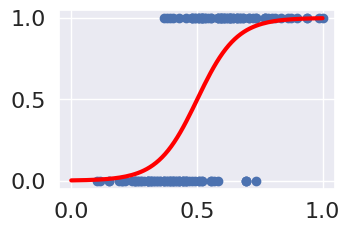

In [31]:
from scipy.special import expit



loss = expit(sorted(X_test.T[0].reshape(-1,1)) *logr.coef_.T[0] + logr.intercept_).ravel()
plt.plot(sorted(X_test.T[0].reshape(-1,1)), loss, color='red', linewidth=3)
plt.scatter(X_res_t.T[0].reshape(-1,1), y_res_t)
#plt.xlabel(selected_columns[0], fontsize=16)
#plt.ylabel('Occupancy', fontsize=16)
plt.tick_params(axis='both', which='major')
plt.show()

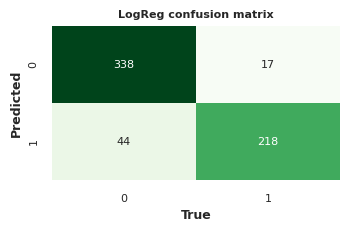

In [32]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False, fmt=".4g")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LogReg confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'LogReg_conf_matrix.pdf'), format='pdf')
plt.show()

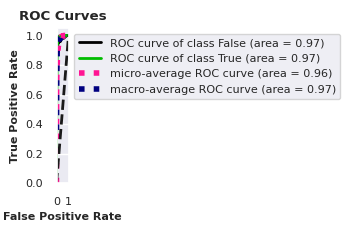

0.9694925276851951


In [33]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

y_test_pred_proba = logr.predict_proba(X_test.T[0].reshape(-1,1))
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'LogReg_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


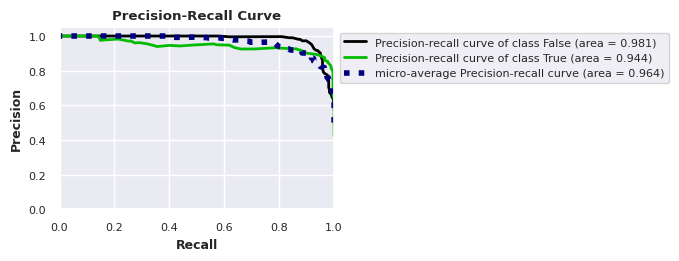

In [34]:
from scikitplot.metrics import plot_precision_recall

plot_precision_recall(y_test, logr.predict_proba(X_test.T[0].reshape(-1,1)))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# Suppport Vector Machine

In [35]:
pca = PCA(n_components=2)
pca.fit(X_res_t)
X_pca = pca.transform(X_res_t)

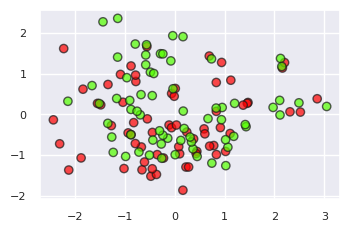

In [36]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

## Linear SVM

In [37]:
from sklearn.svm import LinearSVC

In [38]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    

    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_res_t, y_res_t)
    y_pred = lin_svc.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-06-20 17:10:37,617] A new study created in memory with name: no-name-500b6d20-8ab4-4b2a-91b7-ca6ccc3468b9
[W 2023-06-20 17:10:37,646] Trial 1 failed with parameters: {'penalty': 'l1', 'C': 86.65622079953776, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.loca

[W 2023-06-20 17:10:37,798] Trial 8 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-06-20 17:10:37,932] Trial 5 finished with value: 0.9302325581395349 and parameters: {'penalty': 'l2', 'C': 26.103255252558935, 'loss': 'hinge'}. Best is trial 0 with value: 0.9302325581395349.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-06-20 17:10:37,970] Trial 7 finished with value: 0.9302325581395349 and parameters: {'penalty': 'l2', 'C': 41.132326111051356, 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.9302325581395349.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Co

[W 2023-06-20 17:10:38,372] Trial 20 failed with value None.
[W 2023-06-20 17:10:38,375] Trial 18 failed with parameters: {'penalty': 'l1', 'C': 80.47938617663826, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 12

[W 2023-06-20 17:10:38,739] Trial 28 failed with parameters: {'penalty': 'l1', 'C': 2.0929898642646734, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

[W 2023-06-20 17:10:39,041] Trial 33 failed with value None.
[W 2023-06-20 17:10:39,030] Trial 35 failed with parameters: {'penalty': 'l1', 'C': 1.2753240777090653, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[W 2023-06-20 17:10:39,182] Trial 38 failed with parameters: {'penalty': 'l1', 'C': 0.41089869700958026, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_libline

[W 2023-06-20 17:10:39,312] Trial 45 failed with value None.
[W 2023-06-20 17:10:39,331] Trial 43 failed with value None.
[W 2023-06-20 17:10:39,343] Trial 46 failed with parameters: {'penalty': 'l1', 'C': 5.267686293681745, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djan

[W 2023-06-20 17:10:39,513] Trial 47 failed with value None.
[W 2023-06-20 17:10:39,528] Trial 51 failed with value None.
[W 2023-06-20 17:10:39,540] Trial 52 failed with parameters: {'penalty': 'l1', 'C': 0.3659172415036487, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/dja

[W 2023-06-20 17:10:39,656] Trial 56 failed with parameters: {'penalty': 'l1', 'C': 3.433514823887686, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear

[W 2023-06-20 17:10:39,918] Trial 62 failed with value None.
[W 2023-06-20 17:10:39,914] Trial 65 failed with parameters: {'penalty': 'l1', 'C': 2.749075431904383, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-06-20 17:10:40,070] Trial 69 failed with value None.
[W 2023-06-20 17:10:40,070] Trial 70 failed with parameters: {'penalty': 'l1', 'C': 1.030351287754094, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-06-20 17:10:40,273] Trial 74 failed with value None.
[W 2023-06-20 17:10:40,301] Trial 76 failed with parameters: {'penalty': 'l1', 'C': 1.7453040143950336, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[W 2023-06-20 17:10:40,443] Trial 79 failed with parameters: {'penalty': 'l1', 'C': 2.997786953405236, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear

[W 2023-06-20 17:10:40,624] Trial 87 failed with value None.
[W 2023-06-20 17:10:40,614] Trial 85 failed with value None.
[W 2023-06-20 17:10:40,612] Trial 86 failed with value None.
[W 2023-06-20 17:10:40,706] Trial 88 failed with parameters: {'penalty': 'l1', 'C': 1.2775319599177344, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_,

[W 2023-06-20 17:10:40,804] Trial 93 failed with parameters: {'penalty': 'l1', 'C': 3.478611008758783, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear

[W 2023-06-20 17:10:41,011] Trial 100 failed with parameters: {'penalty': 'l1', 'C': 2.311780207672193, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

[W 2023-06-20 17:10:41,202] Trial 105 failed with value None.
[W 2023-06-20 17:10:41,214] Trial 107 failed with parameters: {'penalty': 'l1', 'C': 0.061158883568587896, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10

[W 2023-06-20 17:10:41,368] Trial 112 failed with parameters: {'penalty': 'l1', 'C': 5.052487004599369, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

[W 2023-06-20 17:10:41,527] Trial 115 failed with value None.
[W 2023-06-20 17:10:41,531] Trial 117 failed with value None.
[W 2023-06-20 17:10:41,532] Trial 118 failed with parameters: {'penalty': 'l1', 'C': 0.34740448236711785, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home

[W 2023-06-20 17:10:41,666] Trial 122 failed with value None.
[W 2023-06-20 17:10:41,727] Trial 123 failed with value None.
[W 2023-06-20 17:10:41,732] Trial 124 failed with parameters: {'penalty': 'l1', 'C': 5.729835277006494, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/d

[W 2023-06-20 17:10:41,957] Trial 130 failed with value None.
[W 2023-06-20 17:10:41,950] Trial 129 failed with parameters: {'penalty': 'l1', 'C': 1.363306601390338, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/si

[W 2023-06-20 17:10:42,099] Trial 134 failed with value None.
[W 2023-06-20 17:10:42,153] Trial 136 failed with parameters: {'penalty': 'l1', 'C': 1.9638630566892434, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/s

[W 2023-06-20 17:10:42,277] Trial 142 failed with parameters: {'penalty': 'l1', 'C': 3.937379469559339, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

[W 2023-06-20 17:10:42,415] Trial 145 failed with value None.
[W 2023-06-20 17:10:42,438] Trial 147 failed with value None.
[W 2023-06-20 17:10:42,444] Trial 148 failed with parameters: {'penalty': 'l1', 'C': 0.5847713203010798, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2328165744.py", line 11, in objective_fun
    lin_svc.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/

In [39]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(X_res_t, y_res_t)

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'penalty': 'l2', 'C': 9.49526789592648, 'loss': 'squared_hinge'}
              precision    recall  f1-score   support

       False       0.92      0.99      0.96       355
        True       0.99      0.89      0.94       262

    accuracy                           0.95       617
   macro avg       0.96      0.94      0.95       617
weighted avg       0.95      0.95      0.95       617

Accuracy 0.9481361426256077
F1-score [0.95652174 0.93574297]


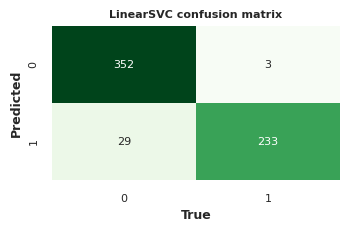

In [40]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False,fmt=".4g")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('LinearSVC confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'LinearSVC_conf_matrix.pdf'), format='pdf')
plt.show()

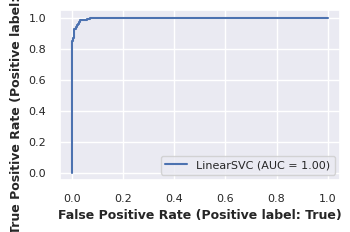

In [41]:
from sklearn.metrics import RocCurveDisplay

linear_svc_disp = RocCurveDisplay.from_estimator(lin_svc, X_test, y_test)
plt.savefig(os.path.join(IMAGE_FOLDER, 'LinearSVC_ROC.pdf'), format='pdf')

In [42]:
decision_function = lin_svc.decision_function(X_res_t)
support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
support_vectors = X_res_t[support_vector_indices]

In [43]:
support_vectors_pca = pca.transform(support_vectors)

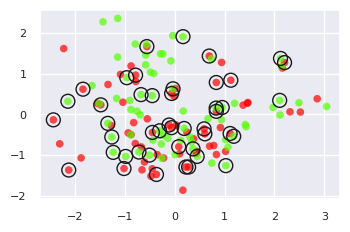

In [44]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


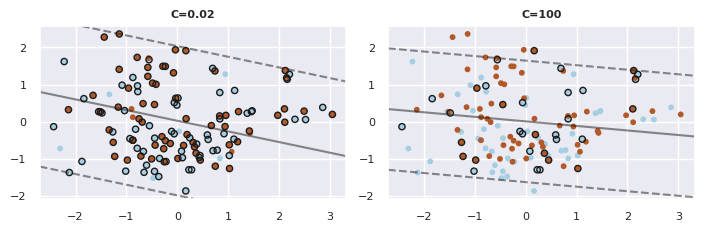

In [45]:
plt.figure(figsize=default_style.SHORT_FULLSIZE_FIGURE)

for i, C in enumerate([0.02, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="squared_hinge", penalty='l2', random_state=42).fit(X_res_t, y_res_t)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X_res_t)
#     we can also calculate the decision function manually
#     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
    support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
    support_vectors = X_res_t[support_vector_indices]
    support_vectors_pca = pca.transform(support_vectors)

    plt.subplot(1, 2, i + 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=10, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=20,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
    #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_FOLDER, f'LinearSVC_C_{C}.pdf'), format='pdf')
plt.show()

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [46]:
from sklearn.svm import SVC

In [47]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.01,100)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    

    lin_svc = SVC(kernel=kernel, gamma=gamma, C=C)

    lin_svc.fit(X_res_t, y_res_t)
    y_pred = lin_svc.predict(X_res_v)

    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-06-20 17:10:53,015] A new study created in memory with name: no-name-ada8f92a-09de-4ef9-a9bd-75cd3747dd56
[I 2023-06-20 17:10:53,054] Trial 0 finished with value: 0.9534883720930233 and parameters: {'kernel': 'rbf', 'C': 92.24758261559839, 'gamma': 0.10521972134792887}. Best is trial 0 with value: 0.9534883720930233.
[I 2023-06-20 17:10:53,066] Trial 3 finished with value: 0.6046511627906976 and parameters: {'kernel': 'rbf', 'C': 19.617009514788492, 'gamma': 0.7757089647518765}. Best is trial 0 with value: 0.9534883720930233.
[I 2023-06-20 17:10:53,071] Trial 1 finished with value: 0.3953488372093023 and parameters: {'kernel': 'sigmoid', 'C': 21.93293225652922, 'gamma': 0.4705773176718232}. Best is trial 0 with value: 0.9534883720930233.
[I 2023-06-20 17:10:53,076] Trial 2 finished with value: 0.8372093023255814 and parameters: {'kernel': 'sigmoid', 'C': 71.8853214717678, 'gamma': 0.3277388239156792}. Best is trial 0 with value: 0.9534883720930233.
[I 2023-06-20 17:10:53,106] T

[I 2023-06-20 17:10:54,358] Trial 38 finished with value: 0.9767441860465116 and parameters: {'kernel': 'poly', 'C': 20.443430139724224, 'gamma': 0.2928436386545014}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:54,412] Trial 39 finished with value: 0.8604651162790697 and parameters: {'kernel': 'rbf', 'C': 18.110560518487354, 'gamma': 0.3105885802715424}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:54,487] Trial 41 finished with value: 0.6046511627906976 and parameters: {'kernel': 'rbf', 'C': 18.52961587241804, 'gamma': 0.7454315600688253}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:54,504] Trial 40 finished with value: 0.6046511627906976 and parameters: {'kernel': 'rbf', 'C': 16.631614968466167, 'gamma': 0.7405171973760873}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:54,507] Trial 42 finished with value: 0.6046511627906976 and parameters: {'kernel': 'sigmoid', 'C': 17.073894220048494, 'gam

[I 2023-06-20 17:10:56,148] Trial 78 finished with value: 0.6744186046511628 and parameters: {'kernel': 'rbf', 'C': 35.93606910598807, 'gamma': 0.6088902030204196}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:56,173] Trial 77 finished with value: 0.6976744186046512 and parameters: {'kernel': 'rbf', 'C': 76.10911809533748, 'gamma': 0.5370398979510285}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:56,200] Trial 80 finished with value: 0.9767441860465116 and parameters: {'kernel': 'poly', 'C': 62.943767294468415, 'gamma': 0.4875614456695071}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:56,259] Trial 79 finished with value: 0.9767441860465116 and parameters: {'kernel': 'poly', 'C': 22.143618129834167, 'gamma': 0.5516810724086904}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:56,371] Trial 83 finished with value: 0.9767441860465116 and parameters: {'kernel': 'poly', 'C': 30.447701771921146, 'gamma'

[I 2023-06-20 17:10:58,129] Trial 116 finished with value: 0.9767441860465116 and parameters: {'kernel': 'poly', 'C': 58.634712363108335, 'gamma': 0.21622090122757062}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:58,147] Trial 117 finished with value: 0.9767441860465116 and parameters: {'kernel': 'poly', 'C': 53.58328933939639, 'gamma': 0.20634937829960442}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:58,209] Trial 118 finished with value: 0.9767441860465116 and parameters: {'kernel': 'poly', 'C': 59.023358806384806, 'gamma': 0.20913971833924472}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:58,240] Trial 119 finished with value: 0.9767441860465116 and parameters: {'kernel': 'poly', 'C': 53.10029078222247, 'gamma': 0.3093775540642452}. Best is trial 8 with value: 0.9767441860465116.
[I 2023-06-20 17:10:58,323] Trial 120 finished with value: 0.9767441860465116 and parameters: {'kernel': 'poly', 'C': 47.43527954736072

In [48]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(X_res_t, y_res_t)

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'kernel': 'poly', 'C': 76.62134304773959, 'gamma': 0.751299466204848}
              precision    recall  f1-score   support

       False       0.93      0.99      0.96       355
        True       0.99      0.90      0.94       262

    accuracy                           0.95       617
   macro avg       0.96      0.94      0.95       617
weighted avg       0.95      0.95      0.95       617

Accuracy 0.9513776337115073
F1-score [0.95912807 0.94      ]


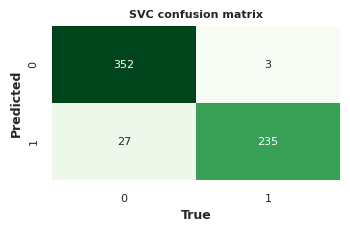

In [49]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False, fmt=".4g")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('SVC confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'SVC_conf_matrix.pdf'), format='pdf')
plt.show()

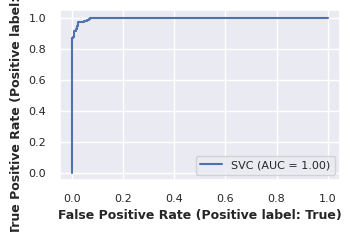

In [50]:
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)
plt.savefig(os.path.join(IMAGE_FOLDER, 'SVC_ROC.pdf'), format='pdf')

In [51]:
support_vectors_pca = pca.transform(svc.support_vectors_)

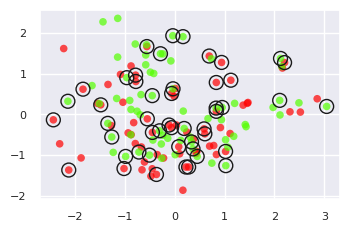

In [52]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [53]:
decision_function = svc.decision_function(X_res_t)
support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
support_vectors = X_res_t[support_vector_indices]

In [54]:
support_vectors_pca = pca.transform(support_vectors)

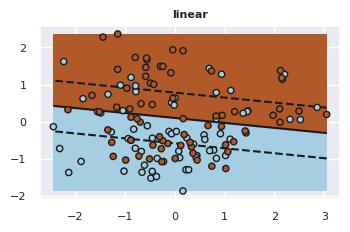

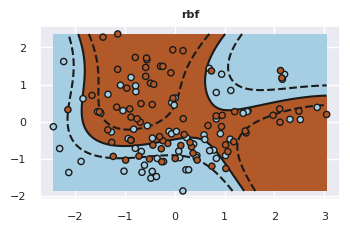

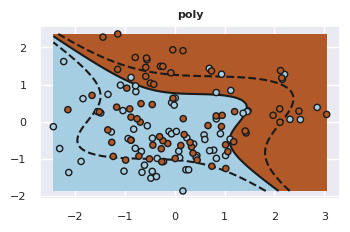

In [55]:
for kernel in ('linear', 'rbf', 'poly'):
    clf = SVC(kernel=kernel, gamma=0.1, C=26)
    clf.fit(X_res_t, y_res_t)

    plt.figure(figsize=default_style.SHORT_HALFSIZE_FIGURE)
    plt.clf()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
#     plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=80, facecolors='none',
#                 zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X_pca[:, 0].min()
    x_max = X_pca[:, 0].max()
    y_min = X_pca[:, 1].min()
    y_max = X_pca[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    clf.fit(X_pca, y_res_t)
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
    plt.savefig(os.path.join(IMAGE_FOLDER, f'SVC_kernel_{kernel}.pdf'), format='pdf')
plt.show()

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [56]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

2023-06-20 17:11:27.480037: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 17:11:28.246315: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 17:11:28.248015: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 17:11:30.732863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [57]:
from scikeras.wrappers import KerasClassifier

In [58]:
from sklearn.model_selection import RandomizedSearchCV

In [59]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(n_classes_, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [60]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [61]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    net.fit(X_res_t, y_res_t, epochs=50)
    y_pred = net.predict(X_res_v).astype(int)
#     print(y_pred.shape, y_res_v.shape)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-06-20 17:11:33,757] A new study created in memory with name: no-name-df5d9441-8b9f-4ec1-ae22-58ffcbd1b39c
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10) wh

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
5/5 [==============================] - 5s 31ms/step - loss: 0.7450 - accuracy: 0.4030
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 0.7172 - accuracy: 0.4254
Epoch 3/50
5/5 [==============================] - 0s 33ms/step - loss: 0.7045 - accuracy: 0.4925
Epoch 4/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6712 - accuracy: 0.5821
Epoch 5/50
5/5 [==============================] - 0s 27ms/step - loss: 0.6557 - accuracy: 0.5896
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6132 - accuracy: 0.7313
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6600 - accuracy: 0.5000
Epoch 7/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6134 - accuracy: 0.7537
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 0.5932 - accuracy: 0.7910
Epoch 8/50
5/5 [==============================] - 0s 36ms/step - loss: 0.6004 - accuracy: 0.72

5/5 [==============================] - 0s 28ms/step - loss: 0.6957 - accuracy: 0.5075
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 0.3146 - accuracy: 0.9403
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2946 - accuracy: 0.9104
Epoch 35/50
5/5 [==============================] - 0s 30ms/step - loss: 0.5525 - accuracy: 0.8507
Epoch 37/50
5/5 [==============================] - 0s 33ms/step - loss: 0.6895 - accuracy: 0.5149
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 0.3152 - accuracy: 0.8806
Epoch 4/50
5/5 [==============================] - 0s 27ms/step - loss: 0.6897 - accuracy: 0.5000
Epoch 37/50
Epoch 5/50
Epoch 4/50
5/5 [==============================] - 0s 25ms/step - loss: 0.4109 - accuracy: 0.8358
Epoch 39/50
Epoch 38/50
5/5 [==============================] - 0s 27ms/step - loss: 0.2838 - accuracy: 0.9403
Epoch 40/50
5/5 [==============================] - 0s 27ms/step - loss: 0.3422 - accuracy: 0.9030
Ep

5/5 [==============================] - 0s 13ms/step - loss: 0.1266 - accuracy: 0.9328
Epoch 18/50
5/5 [==============================] - 0s 18ms/step - loss: 0.5714 - accuracy: 0.9254
Epoch 20/50
5/5 [==============================] - 0s 20ms/step - loss: 0.1266 - accuracy: 0.9403
Epoch 19/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5518 - accuracy: 0.9179
Epoch 21/50
5/5 [==============================] - 0s 14ms/step - loss: 0.1618 - accuracy: 0.9403
Epoch 22/50
Epoch 21/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1316 - accuracy: 0.9701
Epoch 22/50
5/5 [==============================] - 0s 21ms/step - loss: 0.5139 - accuracy: 0.9179
Epoch 23/50
5/5 [==============================] - 0s 19ms/step - loss: 0.2143 - accuracy: 0.9030
Epoch 23/50
Epoch 24/50
2/2 [==============================] - 1s 41ms/step
Epoch 25/50
3/5 [=================>............] - ETA: 0s - loss: 0.0876 - accuracy: 0.9583

[I 2023-06-20 17:11:47,845] Trial 2 finished with value: 0.9302325581395349 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 2 with value: 0.9302325581395349.


5/5 [==============================] - 0s 27ms/step - loss: 0.4445 - accuracy: 0.9328
Epoch 26/50
5/5 [==============================] - 0s 38ms/step - loss: 0.0956 - accuracy: 0.9552
Epoch 25/50
5/5 [==============================] - 0s 18ms/step - loss: 0.4239 - accuracy: 0.9179
Epoch 27/50
5/5 [==============================] - 0s 18ms/step - loss: 0.1051 - accuracy: 0.9627


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 26/50
5/5 [==============================] - 0s 23ms/step - loss: 0.0959 - accuracy: 0.9478
Epoch 27/50
5/5 [==============================] - 0s 12ms/step - loss: 0.3900 - accuracy: 0.9030
Epoch 29/50
5/5 [==============================] - 0s 18ms/step - loss: 0.0914 - accuracy: 0.9478
Epoch 28/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0900 - accuracy: 0.9552
Epoch 29/50
Epoch 31/50
5/5 [==============================] - 0s 14ms/step - loss: 0.3498 - accuracy: 0.9254
Epoch 30/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1032 - accuracy: 0.9552
Epoch 31/50
5/5 [==============================] - 0s 18ms/step - loss: 0.3270 - accuracy: 0.9328
Epoch 33/50
Epoch 1/50
5/5 [==============================] - 0s 18ms/step - loss: 0.3123 - accuracy: 0.9179
Epoch 32/50
Epoch 34/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0928 - accuracy: 0.9701
Epoch 35/50
Epoch 33/50
5/5 [==============================] - 0s 15ms/step - loss:

[I 2023-06-20 17:11:50,479] Trial 3 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.


Epoch 45/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0593 - accuracy: 0.9776
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0964 - accuracy: 0.9375

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 33ms/step - loss: 0.2055 - accuracy: 0.9328
Epoch 49/50
5/5 [==============================] - 0s 29ms/step - loss: 0.0815 - accuracy: 0.9776
Epoch 48/50
Epoch 50/50
5/5 [==============================] - 0s 34ms/step - loss: 0.0683 - accuracy: 0.9701
Epoch 49/50
5/5 [==============================] - 0s 26ms/step - loss: 0.0968 - accuracy: 0.9627
Epoch 50/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0319 - accuracy: 1.0000
Epoch 1/50
2/2 [==============================] - 0s 9ms/step


[I 2023-06-20 17:11:51,877] Trial 0 finished with value: 0.9534883720930233 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical

2/2 [==============================] - 0s 19ms/step


[I 2023-06-20 17:11:52,215] Trial 1 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical dis

Epoch 1/50
Epoch 1/50
5/5 [==============================] - 8s 23ms/step - loss: 0.7085 - accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 0s 26ms/step - loss: 0.7025 - accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6964 - accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6935 - accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 32ms/step - loss: 0.6926 - accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6910 - accuracy: 0.5000
Epoch 7/50
5/5 [==============================] - 0s 29ms/step - loss: 0.6906 - accuracy: 0.5000
Epoch 8/50
5/5 [==============================] - 0s 15ms/step - loss: 0.6901 - accuracy: 0.5000
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6894 - accuracy: 0.5000
Epoch 10/50
5/5 [==============================] - 0s 28ms/step - loss: 0.6887 - accuracy: 0.6119
Epoch 11/50
5/5 [=

5/5 [==============================] - 0s 24ms/step - loss: 0.3966 - accuracy: 0.8731
Epoch 45/50
Epoch 23/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6088 - accuracy: 0.9254
Epoch 10/50
5/5 [==============================] - 0s 27ms/step - loss: 0.1804 - accuracy: 0.9328
Epoch 46/50
Epoch 8/50
5/5 [==============================] - 0s 35ms/step - loss: 0.6040 - accuracy: 0.9254
Epoch 25/50
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2674 - accuracy: 0.8438Epoch 26/50
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.2325 - accuracy: 0.9219Epoch 27/50
Epoch 49/50
Epoch 13/50
5/5 [==============================] - 0s 26ms/step - loss: 0.2328 - accuracy: 0.9179
Epoch 11/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1211 - accuracy: 0.9552
Epoch 28/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1164 - accuracy: 0.9478
Epoch 30/50
Epoch 13/50
5/5 [==============================] - 0s 18ms/

5/5 [==============================] - 0s 23ms/step - loss: 0.0920 - accuracy: 0.9552
Epoch 25/50
Epoch 40/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1387 - accuracy: 0.9478
Epoch 23/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1935 - accuracy: 0.9179
Epoch 24/50
5/5 [==============================] - 0s 27ms/step - loss: 0.0653 - accuracy: 0.9701
Epoch 26/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0759 - accuracy: 0.9627
Epoch 42/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2783 - accuracy: 0.8881
Epoch 43/50
Epoch 26/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0660 - accuracy: 0.9776
Epoch 28/50
Epoch 44/50
5/5 [==============================] - 0s 27ms/step - loss: 0.1045 - accuracy: 0.9552
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0520 - accuracy: 1.0000Epoch 29/50
Epoch 30/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0600 - accurac

[I 2023-06-20 17:12:06,734] Trial 5 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 27ms/step - loss: 0.0968 - accuracy: 0.9627
Epoch 41/50
5/5 [==============================] - 0s 22ms/step - loss: 0.1208 - accuracy: 0.9552
Epoch 42/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 22ms/step - loss: 0.0896 - accuracy: 0.9627
Epoch 43/50
5/5 [==============================] - 0s 38ms/step - loss: 0.0943 - accuracy: 0.9552
Epoch 43/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0832 - accuracy: 0.9776
Epoch 44/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0942 - accuracy: 0.9552
Epoch 44/50
5/5 [==============================] - 0s 32ms/step - loss: 0.0750 - accuracy: 0.9627
Epoch 45/50
5/5 [==============================] - 0s 39ms/step - loss: 0.0996 - accuracy: 0.9552
Epoch 45/50
5/5 [==============================] - 0s 28ms/step - loss: 0.0886 - accuracy: 0.9627
Epoch 46/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0709 - accuracy: 0.9701
Epoch 47/50
2/2 [==============================] - 1s 14ms/stepss: 0.0616 - accuracy: 0.98
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0553 - accuracy: 0.9688

[I 2023-06-20 17:12:07,811] Trial 4 finished with value: 0.9534883720930233 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


4/5 [=======================>......] - ETA: 0s - loss: 0.0737 - accuracy: 0.9688Epoch 1/50
Epoch 48/50
5/5 [==============================] - 0s 33ms/step - loss: 0.0761 - accuracy: 0.9627
Epoch 49/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 26ms/step - loss: 0.0817 - accuracy: 0.9627
Epoch 49/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0455 - accuracy: 0.9851
Epoch 50/50
5/5 [==============================] - 0s 29ms/step - loss: 0.0776 - accuracy: 0.9552
Epoch 1/50
2/2 [==============================] - 0s 7ms/step


[I 2023-06-20 17:12:09,255] Trial 6 finished with value: 0.9534883720930233 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.
[I 2023-06-20 17:12:09,266] Trial 7 finished with value: 0.9534883720930233 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but

Epoch 1/50
Epoch 1/50
5/5 [==============================] - 5s 21ms/step - loss: 0.7127 - accuracy: 0.5149
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6948 - accuracy: 0.5224
Epoch 3/50
5/5 [==============================] - 0s 27ms/step - loss: 0.6883 - accuracy: 0.5522
Epoch 4/50
5/5 [==============================] - 0s 30ms/step - loss: 0.6800 - accuracy: 0.5970
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6683 - accuracy: 0.6269
Epoch 6/50
5/5 [==============================] - 0s 27ms/step - loss: 0.6584 - accuracy: 0.6866
Epoch 7/50
5/5 [==============================] - 0s 31ms/step - loss: 0.6398 - accuracy: 0.7463
Epoch 8/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6304 - accuracy: 0.7687
Epoch 9/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6227 - accuracy: 0.8134
Epoch 10/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6148 - accuracy: 0.8060
Epoch 11/50
5/5 [=

5/5 [==============================] - 0s 44ms/step - loss: 0.3714 - accuracy: 0.9104
Epoch 2/50
5/5 [==============================] - 0s 33ms/step - loss: 0.5565 - accuracy: 0.8209
Epoch 17/50
Epoch 35/50
5/5 [==============================] - 0s 30ms/step - loss: 0.6939 - accuracy: 0.5000
Epoch 19/50
Epoch 18/50
5/5 [==============================] - 0s 43ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 37/50
Epoch 20/50
Epoch 19/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6920 - accuracy: 0.5000
Epoch 38/50
Epoch 21/50
Epoch 20/50
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.9104Epoch 39/50
Epoch 22/50
5/5 [==============================] - 0s 39ms/step - loss: 0.6915 - accuracy: 0.5821
Epoch 21/50
Epoch 7/50
5/5 [==============================] - 0s 28ms/step - loss: 0.5061 - accuracy: 0.8358
Epoch 23/50
Epoch 22/50
5/5 [==============================] - 0s 26ms/step - loss: 0.4863 - accuracy: 0.8657
Epoch 41/50
5/5 [==

5/5 [==============================] - 0s 30ms/step - loss: 0.3648 - accuracy: 0.9030
Epoch 34/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6605 - accuracy: 0.5522
Epoch 35/50
Epoch 20/50
5/5 [==============================] - 0s 20ms/step - loss: 0.3382 - accuracy: 0.8955
Epoch 36/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6935 - accuracy: 0.5000
Epoch 38/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6360 - accuracy: 0.5373
Epoch 38/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 24/50
Epoch 40/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6047 - accuracy: 0.8134
Epoch 40/50
5/5 [==============================] - 0s 25ms/step - loss: 0.3029 - accuracy: 0.9552
Epoch 41/50
5/5 [==============================] - 0s 29ms/step - loss: 0.6932 - accuracy: 0.4776
Epoch 42/50
5/5 [==============================] - 0s 25ms/step - loss: 0.5729 - accuracy: 0.8657
Epoch 42

[I 2023-06-20 17:12:23,846] Trial 8 finished with value: 0.8837209302325582 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 13ms/step - loss: 0.4144 - accuracy: 0.9030
Epoch 36/50
5/5 [==============================] - 0s 18ms/step - loss: 0.3944 - accuracy: 0.9179
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3669 - accuracy: 0.9375

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 31ms/step - loss: 0.3774 - accuracy: 0.9179
Epoch 38/50
5/5 [==============================] - 0s 14ms/step - loss: 0.3718 - accuracy: 0.9478
Epoch 39/50
5/5 [==============================] - 0s 26ms/step - loss: 0.3511 - accuracy: 0.9328
Epoch 40/50
5/5 [==============================] - 0s 12ms/step - loss: 0.3356 - accuracy: 0.9254
Epoch 41/50
5/5 [==============================] - 0s 16ms/step - loss: 0.3230 - accuracy: 0.9254
Epoch 42/50
5/5 [==============================] - 0s 23ms/step - loss: 0.3160 - accuracy: 0.9328
Epoch 43/50


[I 2023-06-20 17:12:24,770] Trial 11 finished with value: 0.9069767441860465 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 29ms/step - loss: 0.3018 - accuracy: 0.9254
Epoch 44/50
5/5 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.9254

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 21ms/step - loss: 0.2913 - accuracy: 0.9254
Epoch 45/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2824 - accuracy: 0.9328
Epoch 46/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2765 - accuracy: 0.9328
Epoch 47/50
5/5 [==============================] - 0s 15ms/step - loss: 0.2688 - accuracy: 0.9328
Epoch 48/50
5/5 [==============================] - 0s 33ms/step - loss: 0.2572 - accuracy: 0.9328
Epoch 49/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2595 - accuracy: 0.9254
Epoch 50/50
2/2 [==============================] - 0s 15ms/step


[I 2023-06-20 17:12:26,212] Trial 10 finished with value: 0.3953488372093023 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical 

2/2 [==============================] - 0s 14ms/step


[I 2023-06-20 17:12:26,511] Trial 9 finished with value: 0.9302325581395349 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical

Epoch 1/50
Epoch 1/50
5/5 [==============================] - 6s 31ms/step - loss: 0.6564 - accuracy: 0.6194
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6291 - accuracy: 0.7239
Epoch 3/50
5/5 [==============================] - 0s 31ms/step - loss: 0.6082 - accuracy: 0.7015
Epoch 4/50
5/5 [==============================] - 0s 29ms/step - loss: 0.5869 - accuracy: 0.7687
Epoch 5/50
5/5 [==============================] - 0s 23ms/step - loss: 0.5733 - accuracy: 0.7015
Epoch 6/50
5/5 [==============================] - 0s 27ms/step - loss: 0.5340 - accuracy: 0.8209
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 0.5223 - accuracy: 0.8284
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 0.4982 - accuracy: 0.8284
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 0.4754 - accuracy: 0.8507
Epoch 10/50
5/5 [==============================] - 0s 35ms/step - loss: 0.4525 - accuracy: 0.8731
Epoch 11/50
5/5 [=

5/5 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.8358Epoch 12/50
Epoch 40/50
5/5 [==============================] - 0s 21ms/step - loss: 0.5799 - accuracy: 0.8358
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6821 - accuracy: 0.8060
Epoch 13/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6716 - accuracy: 0.5000
Epoch 10/50
Epoch 41/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6795 - accuracy: 0.8806
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9104Epoch 21/50
Epoch 11/50
5/5 [==============================] - 0s 26ms/step - loss: 0.2103 - accuracy: 0.9104
Epoch 42/50
5/5 [==============================] - 0s 12ms/step - loss: 0.5401 - accuracy: 0.8582
Epoch 15/50
5/5 [==============================] - 0s 32ms/step - loss: 0.1740 - accuracy: 0.9254
Epoch 12/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6700 - accuracy: 0.7463
Epoch 13/

5/5 [==============================] - 0s 13ms/step - loss: 0.2875 - accuracy: 0.9328
Epoch 36/50
Epoch 26/50
5/5 [==============================] - 0s 12ms/step - loss: 0.5983 - accuracy: 0.8507
Epoch 31/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4533 - accuracy: 0.8582
Epoch 27/50
Epoch 37/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2668 - accuracy: 0.9254
Epoch 38/50
5/5 [==============================] - 0s 13ms/step - loss: 0.5834 - accuracy: 0.9030
Epoch 28/50
Epoch 33/50
5/5 [==============================] - 0s 10ms/step - loss: 0.5766 - accuracy: 0.9179
Epoch 29/50
Epoch 34/50
Epoch 39/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2472 - accuracy: 0.9254
Epoch 35/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2404 - accuracy: 0.9254
Epoch 41/50
5/5 [==============================] - 0s 18ms/step - loss: 0.5602 - accuracy: 0.8881
Epoch 36/50
5/5 [==============================] - 0s 15ms/step - loss:

[I 2023-06-20 17:12:38,905] Trial 13 finished with value: 0.9534883720930233 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 19ms/step - loss: 0.2266 - accuracy: 0.9328
Epoch 47/50
5/5 [==============================] - 0s 19ms/step - loss: 0.2220 - accuracy: 0.9328
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1561 - accuracy: 0.9688

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 16ms/step - loss: 0.2156 - accuracy: 0.9254
Epoch 49/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2118 - accuracy: 0.9328
Epoch 50/50
2/2 [==============================] - 0s 16ms/step


[I 2023-06-20 17:12:39,443] Trial 15 finished with value: 0.9534883720930233 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


Epoch 1/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

2/2 [==============================] - 0s 11ms/step


[I 2023-06-20 17:12:39,991] Trial 14 finished with value: 0.9534883720930233 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorica

Epoch 1/50
Epoch 1/50
2/2 [==============================] - 0s 20ms/step


[I 2023-06-20 17:12:41,814] Trial 12 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distri

Epoch 1/50
5/5 [==============================] - 8s 44ms/step - loss: 0.7381 - accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 0s 25ms/step - loss: 0.7185 - accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 39ms/step - loss: 0.7079 - accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6994 - accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 27ms/step - loss: 0.6951 - accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6914 - accuracy: 0.5000
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6907 - accuracy: 0.6493
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6902 - accuracy: 0.5522
Epoch 10/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6894 - accuracy: 0.5149
Epoch 11/50
5/5 [============

4/5 [=======================>......] - ETA: 0s - loss: 0.5919 - accuracy: 0.9141Epoch 12/50
Epoch 23/50
5/5 [==============================] - 0s 29ms/step - loss: 0.2464 - accuracy: 0.9328
Epoch 13/50
Epoch 24/50
4/5 [=======================>......] - ETA: 0s - loss: 0.5820 - accuracy: 0.9062Epoch 25/50
Epoch 14/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2410 - accuracy: 0.9104
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2398 - accuracy: 0.8750Epoch 15/50
Epoch 43/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5684 - accuracy: 0.8806
Epoch 16/50
Epoch 44/50
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9254Epoch 17/50
Epoch 45/50
5/5 [==============================] - 0s 38ms/step - loss: 0.2093 - accuracy: 0.9254
Epoch 28/50
5/5 [==============================] - 0s 22ms/step - loss: 0.5553 - accuracy: 0.8955
Epoch 18/50
Epoch 46/50
5/5 [==============================] - 0s 24ms

[I 2023-06-20 17:12:55,038] Trial 16 finished with value: 0.9534883720930233 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


Epoch 11/50
5/5 [==============================] - 0s 16ms/step - loss: 0.3343 - accuracy: 0.9104


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 13/50
Epoch 40/50
5/5 [==============================] - 0s 25ms/step - loss: 0.3120 - accuracy: 0.9179
Epoch 31/50
5/5 [==============================] - 0s 24ms/step - loss: 0.1517 - accuracy: 0.9328
Epoch 42/50
5/5 [==============================] - 0s 38ms/step - loss: 0.2020 - accuracy: 0.9254
Epoch 33/50
5/5 [==============================] - 0s 46ms/step - loss: 0.2746 - accuracy: 0.9030
Epoch 16/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1463 - accuracy: 0.9403
Epoch 44/50
5/5 [==============================] - 0s 23ms/step - loss: 0.1848 - accuracy: 0.9328
Epoch 17/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1556 - accuracy: 0.9478
Epoch 18/50
Epoch 36/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2372 - accuracy: 0.9104
Epoch 46/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1576 - accuracy: 0.9328
Epoch 37/50
5/5 [==============================] - 0s 31ms/step - loss: 0.2294 - accuracy: 0.9

[I 2023-06-20 17:12:58,945] Trial 18 finished with value: 0.9069767441860465 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


Epoch 40/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1552 - accuracy: 0.9478
Epoch 41/50
5/5 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9403

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 22ms/step - loss: 0.1461 - accuracy: 0.9403
Epoch 42/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1409 - accuracy: 0.9403
Epoch 43/50
5/5 [==============================] - 0s 17ms/step - loss: 0.1343 - accuracy: 0.9403
Epoch 44/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1319 - accuracy: 0.9403
Epoch 45/50
5/5 [==============================] - 0s 20ms/step - loss: 0.1283 - accuracy: 0.9403
Epoch 46/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1263 - accuracy: 0.9403
Epoch 47/50
Epoch 1/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1521 - accuracy: 0.9403
Epoch 48/50
5/5 [==============================] - 0s 36ms/step - loss: 0.1403 - accuracy: 0.9478


[I 2023-06-20 17:13:00,110] Trial 17 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


Epoch 49/50
5/5 [==============================] - 0s 23ms/step - loss: 0.1234 - accuracy: 0.9403
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0548 - accuracy: 1.0000

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 26ms/step - loss: 0.2047 - accuracy: 0.9104
Epoch 1/50
5/5 [==============================] - 7s 13ms/step - loss: 0.6875 - accuracy: 0.5373
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6667 - accuracy: 0.6418
Epoch 3/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6493 - accuracy: 0.6716
Epoch 4/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6280 - accuracy: 0.7537
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6217 - accuracy: 0.6567
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 0.5849 - accuracy: 0.8134
Epoch 7/50
5/5 [==============================] - 0s 13ms/step - loss: 0.5580 - accuracy: 0.8433
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5222 - accuracy: 0.8433
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 0.5008 - accuracy: 0.8582
Epoch 10/50
5/5 [========================

[I 2023-06-20 17:13:04,628] Trial 19 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 28ms/step - loss: 0.3468 - accuracy: 0.8955
Epoch 15/50
5/5 [==============================] - 0s 18ms/step - loss: 0.3221 - accuracy: 0.8955
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3355 - accuracy: 0.8750

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 27ms/step - loss: 0.3024 - accuracy: 0.9104
Epoch 17/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2962 - accuracy: 0.8955
Epoch 18/50
5/5 [==============================] - 0s 19ms/step - loss: 0.2959 - accuracy: 0.9030
Epoch 19/50
5/5 [==============================] - 0s 20ms/step - loss: 0.2679 - accuracy: 0.9030
Epoch 20/50
5/5 [==============================] - 0s 28ms/step - loss: 0.2837 - accuracy: 0.8881
Epoch 21/50
5/5 [==============================] - 0s 25ms/step - loss: 0.2329 - accuracy: 0.9254
Epoch 22/50
5/5 [==============================] - 0s 14ms/step - loss: 0.2651 - accuracy: 0.8955
Epoch 23/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2204 - accuracy: 0.9179
Epoch 24/50
5/5 [==============================] - 0s 34ms/step - loss: 0.2372 - accuracy: 0.9030
Epoch 25/50
5/5 [==============================] - 0s 17ms/step - loss: 0.2209 - accuracy: 0.9254
Epoch 26/50
5/5 [===============

5/5 [==============================] - 0s 11ms/step - loss: 0.2880 - accuracy: 0.8955
Epoch 22/50
Epoch 17/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3966 - accuracy: 0.8806
Epoch 23/50
Epoch 18/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2566 - accuracy: 0.9179
Epoch 24/50
5/5 [==============================] - 0s 10ms/step - loss: 0.3948 - accuracy: 0.8731
Epoch 19/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2318 - accuracy: 0.9179
Epoch 25/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2289 - accuracy: 0.9104
Epoch 26/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3378 - accuracy: 0.8881
Epoch 21/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2109 - accuracy: 0.9179
Epoch 27/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3452 - accuracy: 0.9030
Epoch 22/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2022 - accuracy: 0.9254
Epoch 28/50


[I 2023-06-20 17:13:12,098] Trial 21 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 6s 13ms/step - loss: 0.7067 - accuracy: 0.4925
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6899 - accuracy: 0.4688

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 13ms/step - loss: 0.6911 - accuracy: 0.5373
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6906 - accuracy: 0.6493
Epoch 4/50
2/2 [==============================] - 0s 7ms/steposs: 0.6904 - accuracy: 0.56


[I 2023-06-20 17:13:12,427] Trial 22 finished with value: 0.9069767441860465 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 16ms/step - loss: 0.6887 - accuracy: 0.6119
Epoch 5/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6840 - accuracy: 0.5448
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6742 - accuracy: 0.6562Epoch 1/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 15ms/step - loss: 0.6799 - accuracy: 0.5224
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6760 - accuracy: 0.5299
Epoch 8/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6714 - accuracy: 0.5821
Epoch 9/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6663 - accuracy: 0.6642
Epoch 10/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6599 - accuracy: 0.6493
Epoch 11/50
5/5 [==============================] - 0s 15ms/step - loss: 0.6520 - accuracy: 0.6269
Epoch 12/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6442 - accuracy: 0.5821
Epoch 13/50
5/5 [==============================] - 0s 15ms/step - loss: 0.6317 - accuracy: 0.5448
Epoch 14/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6169 - accuracy: 0.5448
Epoch 15/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6002 - accuracy: 0.5821
Epoch 16/50
5/5 [===================

[I 2023-06-20 17:13:14,085] Trial 20 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 19ms/step - loss: 0.5019 - accuracy: 0.8060
Epoch 23/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4907 - accuracy: 0.8507
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4639 - accuracy: 0.8750

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 16ms/step - loss: 0.4868 - accuracy: 0.8806
Epoch 25/50
5/5 [==============================] - 0s 14ms/step - loss: 0.4745 - accuracy: 0.8433
Epoch 26/50
5/5 [==============================] - 0s 18ms/step - loss: 0.4705 - accuracy: 0.8433
Epoch 27/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4583 - accuracy: 0.8806
Epoch 28/50
5/5 [==============================] - 0s 14ms/step - loss: 0.4470 - accuracy: 0.8657
Epoch 29/50
5/5 [==============================] - 0s 22ms/step - loss: 0.4471 - accuracy: 0.8507
Epoch 30/50
5/5 [==============================] - 0s 14ms/step - loss: 0.4372 - accuracy: 0.8881
Epoch 31/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4281 - accuracy: 0.9104
Epoch 32/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4221 - accuracy: 0.8881
Epoch 33/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4263 - accuracy: 0.9104
Epoch 34/50
5/5 [===============

[I 2023-06-20 17:13:17,191] Trial 23 finished with value: 0.9534883720930233 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


Epoch 13/50
5/5 [==============================] - 0s 12ms/step - loss: 0.5890 - accuracy: 0.8284
Epoch 17/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6023 - accuracy: 0.7836
Epoch 14/50
5/5 [==============================] - 0s 11ms/step - loss: 0.5714 - accuracy: 0.8358
Epoch 15/50
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5742 - accuracy: 0.8438

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 15ms/step - loss: 0.5850 - accuracy: 0.8060
Epoch 20/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5499 - accuracy: 0.8507
Epoch 21/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5764 - accuracy: 0.8209
Epoch 17/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5386 - accuracy: 0.8731
Epoch 22/50
5/5 [==============================] - 0s 15ms/step - loss: 0.5607 - accuracy: 0.8507
Epoch 2/50
Epoch 18/50
5/5 [==============================] - 0s 10ms/step - loss: 0.5638 - accuracy: 0.7761
Epoch 3/50
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5398 - accuracy: 0.8438Epoch 24/50
Epoch 1/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6538 - accuracy: 0.6194
Epoch 20/50
5/5 [==============================] - 0s 12ms/step - loss: 0.5073 - accuracy: 0.8731
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.5284 - accuracy: 0.8507
Epoch 

5/5 [==============================] - 0s 28ms/step - loss: 0.4192 - accuracy: 0.9104
Epoch 22/50
5/5 [==============================] - 0s 26ms/step - loss: 0.3711 - accuracy: 0.8955
Epoch 43/50
5/5 [==============================] - 0s 15ms/step - loss: 0.4032 - accuracy: 0.9328
Epoch 37/50
5/5 [==============================] - 0s 31ms/step - loss: 0.3277 - accuracy: 0.9328
Epoch 24/50
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3782 - accuracy: 0.8125Epoch 25/50
Epoch 45/50
5/5 [==============================] - 0s 24ms/step - loss: 0.3718 - accuracy: 0.9179
Epoch 46/50
Epoch 26/50
5/5 [==============================] - 0s 44ms/step - loss: 0.3465 - accuracy: 0.8806
Epoch 40/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3712 - accuracy: 0.9328
Epoch 27/50
5/5 [==============================] - 0s 19ms/step - loss: 0.3102 - accuracy: 0.9328
Epoch 47/50
5/5 [==============================] - 0s 28ms/step - loss: 0.3579 - accuracy: 0.9179
Ep

5/5 [==============================] - 0s 9ms/step - loss: 0.3925 - accuracy: 0.8955
Epoch 19/50
5/5 [==============================] - 0s 4ms/step - loss: 0.3959 - accuracy: 0.8731
Epoch 20/50
5/5 [==============================] - 0s 6ms/step - loss: 0.3725 - accuracy: 0.9030
Epoch 21/50
2/2 [==============================] - 0s 7ms/steposs: 0.5278 - accuracy: 0.71


[I 2023-06-20 17:13:23,468] Trial 26 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 6ms/step - loss: 0.3873 - accuracy: 0.8731
Epoch 22/50
5/5 [==============================] - 0s 6ms/step - loss: 0.3654 - accuracy: 0.9104
Epoch 23/50
5/5 [==============================] - 0s 6ms/step - loss: 0.3505 - accuracy: 0.9179
Epoch 24/50
5/5 [==============================] - 0s 7ms/step - loss: 0.3424 - accuracy: 0.9104
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2826 - accuracy: 0.9375

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 9ms/step - loss: 0.3283 - accuracy: 0.9104
Epoch 26/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3349 - accuracy: 0.9179
Epoch 27/50
5/5 [==============================] - 0s 6ms/step - loss: 0.3545 - accuracy: 0.8806
Epoch 28/50
5/5 [==============================] - 0s 5ms/step - loss: 0.3101 - accuracy: 0.9179
Epoch 29/50
5/5 [==============================] - 0s 7ms/step - loss: 0.3056 - accuracy: 0.9403
Epoch 30/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2973 - accuracy: 0.9254
Epoch 31/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2902 - accuracy: 0.9403
Epoch 32/50
5/5 [==============================] - 0s 6ms/step - loss: 0.3118 - accuracy: 0.8806
Epoch 33/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2863 - accuracy: 0.9328
Epoch 34/50
5/5 [==============================] - 0s 7ms/step - loss: 0.2757 - accuracy: 0.9254
Epoch 35/50
5/5 [========================

[I 2023-06-20 17:13:25,159] Trial 27 finished with value: 0.7674418604651163 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical dis

Epoch 1/50
5/5 [==============================] - 2s 6ms/step - loss: 0.7305 - accuracy: 0.4552
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 0.7107 - accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6963 - accuracy: 0.4925
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6876 - accuracy: 0.5597
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.4776
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6785 - accuracy: 0.5522
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6747 - accuracy: 0.6119
Epoch 8/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6716 - accuracy: 0.5896
Epoch 9/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6631 - accuracy: 0.7090
Epoch 10/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6580 - accuracy: 0.6642
Epoch 11/50
5/5 [======================

[I 2023-06-20 17:13:26,663] Trial 24 finished with value: 0.9302325581395349 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.


Epoch 23/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5501 - accuracy: 0.8582
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5778 - accuracy: 0.6562

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 21ms/step - loss: 0.5413 - accuracy: 0.7985
Epoch 25/50
5/5 [==============================] - 0s 15ms/step - loss: 0.5249 - accuracy: 0.8507
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4880 - accuracy: 0.7812

[I 2023-06-20 17:13:27,065] Trial 25 finished with value: 0.9302325581395349 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 20ms/step - loss: 0.5154 - accuracy: 0.8582
Epoch 27/50
5/5 [==============================] - 0s 15ms/step - loss: 0.5032 - accuracy: 0.8731
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.5006 - accuracy: 0.8125

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 16ms/step - loss: 0.4930 - accuracy: 0.8657
Epoch 29/50
5/5 [==============================] - 0s 14ms/step - loss: 0.4793 - accuracy: 0.8657
Epoch 30/50
5/5 [==============================] - 0s 24ms/step - loss: 0.4654 - accuracy: 0.8881
Epoch 31/50
5/5 [==============================] - 0s 15ms/step - loss: 0.4545 - accuracy: 0.8881
Epoch 32/50
5/5 [==============================] - 0s 15ms/step - loss: 0.4423 - accuracy: 0.8881
Epoch 33/50
5/5 [==============================] - 2s 13ms/step - loss: 0.7449 - accuracy: 0.5000
Epoch 2/50
Epoch 1/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4407 - accuracy: 0.8731
Epoch 34/50
5/5 [==============================] - 0s 23ms/step - loss: 0.7362 - accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 0.7224 - accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 29ms/step - loss: 0.4123 - accuracy: 0.8731
Epoch 37/50
5/5 [=======

[I 2023-06-20 17:13:30,689] Trial 28 finished with value: 0.8837209302325582 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 32ms/step - loss: 0.6945 - accuracy: 0.5000
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6942 - accuracy: 0.5000

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 29ms/step - loss: 0.6946 - accuracy: 0.5000
Epoch 29/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6951 - accuracy: 0.5000
Epoch 30/50
5/5 [==============================] - 0s 32ms/step - loss: 0.6945 - accuracy: 0.5000
Epoch 31/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6941 - accuracy: 0.5000
Epoch 32/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6939 - accuracy: 0.5000
Epoch 33/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6938 - accuracy: 0.5000
Epoch 34/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6938 - accuracy: 0.5000
Epoch 35/50
Epoch 1/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6937 - accuracy: 0.5000
Epoch 36/50
5/5 [==============================] - 0s 14ms/step - loss: 0.6940 - accuracy: 0.5000
Epoch 37/50
5/5 [==============================] - 5s 18ms/step - loss: 0.7264 - accuracy: 0.5000
Epoch 2/50
5/5 [=====

[I 2023-06-20 17:13:34,192] Trial 29 finished with value: 0.3953488372093023 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 16ms/step - loss: 0.6945 - accuracy: 0.5000
Epoch 21/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6937 - accuracy: 0.5000
Epoch 20/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6936 - accuracy: 0.5000
Epoch 21/50
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6862 - accuracy: 0.5938

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.5000
Epoch 22/50
5/5 [==============================] - 0s 34ms/step - loss: 0.6942 - accuracy: 0.5000
Epoch 23/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6944 - accuracy: 0.5000
Epoch 24/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6936 - accuracy: 0.5000
Epoch 24/50
5/5 [==============================] - 0s 34ms/step - loss: 0.6938 - accuracy: 0.5000
Epoch 25/50
5/5 [==============================] - 0s 30ms/step - loss: 0.6934 - accuracy: 0.5000
Epoch 26/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6941 - accuracy: 0.5000
Epoch 27/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6934 - accuracy: 0.5000
Epoch 27/50
5/5 [==============================] - 0s 36ms/step - loss: 0.6937 - accuracy: 0.5000
Epoch 29/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6936 - accuracy: 0.5075
Epoch 29/50
5/5 [===============

5/5 [==============================] - 0s 23ms/step - loss: 0.7126 - accuracy: 0.5000
Epoch 49/50
Epoch 15/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6940 - accuracy: 0.5000
Epoch 50/50
5/5 [==============================] - 0s 26ms/step - loss: 0.7085 - accuracy: 0.5000
Epoch 16/50
5/5 [==============================] - 0s 24ms/step - loss: 0.7061 - accuracy: 0.5000
Epoch 17/50
5/5 [==============================] - 0s 29ms/step - loss: 0.7052 - accuracy: 0.5000
Epoch 18/50
5/5 [==============================] - 0s 22ms/step - loss: 0.7046 - accuracy: 0.5000
Epoch 19/50
5/5 [==============================] - 0s 18ms/step - loss: 0.7030 - accuracy: 0.5000
Epoch 20/50
5/5 [==============================] - 0s 16ms/step - loss: 0.7005 - accuracy: 0.5000
Epoch 21/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6997 - accuracy: 0.5000
Epoch 22/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6992 - accuracy: 0.5000
Epoch 23/50
2/2 [===

[I 2023-06-20 17:13:39,650] Trial 31 finished with value: 0.3953488372093023 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.


Epoch 24/50
3/5 [=================>............] - ETA: 0s - loss: 0.6937 - accuracy: 0.5208

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 20ms/step - loss: 0.6973 - accuracy: 0.5000
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.7160 - accuracy: 0.3750

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 15ms/step - loss: 0.6964 - accuracy: 0.5000
Epoch 26/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6959 - accuracy: 0.5000
Epoch 27/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6958 - accuracy: 0.5000
Epoch 28/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6957 - accuracy: 0.5000
Epoch 29/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6947 - accuracy: 0.5000
Epoch 30/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6949 - accuracy: 0.5000
Epoch 31/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6949 - accuracy: 0.5000
Epoch 32/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6948 - accuracy: 0.5000
Epoch 33/50
5/5 [==============================] - 6s 12ms/step - loss: 0.8656 - accuracy: 0.5000
Epoch 1/50
5/5 [==============================] - 0s 34ms/step - loss: 0.8408 - accuracy: 0.5000
Epoch 3/50
5/5 [=================

[I 2023-06-20 17:13:44,947] Trial 32 finished with value: 0.6046511627906976 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 21ms/step - loss: 0.7015 - accuracy: 0.5000
Epoch 22/50
5/5 [==============================] - 0s 29ms/step - loss: 0.7003 - accuracy: 0.5000
Epoch 23/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 24ms/step - loss: 0.6986 - accuracy: 0.5000
Epoch 24/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6979 - accuracy: 0.5000
Epoch 25/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6983 - accuracy: 0.5000
Epoch 26/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6977 - accuracy: 0.5000
Epoch 27/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6961 - accuracy: 0.5000
Epoch 28/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6959 - accuracy: 0.5000
Epoch 29/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6958 - accuracy: 0.5000
Epoch 30/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6948 - accuracy: 0.5000
Epoch 31/50
5/5 [==============================] - 0s 15ms/step - loss: 0.6948 - accuracy: 0.5000
Epoch 32/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6948 - accuracy: 0.5000
Epoch 33/50
5/5 [===============

[I 2023-06-20 17:13:49,588] Trial 33 finished with value: 0.5813953488372093 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 3 with value: 0.9534883720930233.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical 

5/5 [==============================] - 9s 32ms/step - loss: 0.8296 - accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 0.7988 - accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.7768 - accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 0.7546 - accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 0.7402 - accuracy: 0.5000
Epoch 6/50
Epoch 1/50
5/5 [==============================] - 0s 22ms/step - loss: 0.7265 - accuracy: 0.5000
Epoch 7/50
5/5 [==============================] - 10s 14ms/step - loss: 0.7066 - accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 0.7173 - accuracy: 0.5000
Epoch 8/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6960 - accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 0.7016 - accuracy: 0.5000
Epoch 11/50
5/5 [=============

5/5 [==============================] - 0s 12ms/step - loss: 0.6974 - accuracy: 0.5000
Epoch 32/50
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6660 - accuracy: 0.8060
Epoch 8/50
Epoch 33/50
5/5 [==============================] - 0s 32ms/step - loss: 0.6730 - accuracy: 0.5149
Epoch 40/50
5/5 [==============================] - 0s 31ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 9/50
Epoch 34/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6717 - accuracy: 0.5224
Epoch 41/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6923 - accuracy: 0.5000
Epoch 35/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6682 - accuracy: 0.5896
Epoch 10/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6583 - accuracy: 0.9179
Epoch 43/50
5/5 [==============================] - 0s 20ms/step - loss: 0.6922 - accuracy: 0.5000
Epoch 11/50
Epoch 36/50
5/5 [==============================] - 0s 28ms/step - loss: 0.6563 - accu

[I 2023-06-20 17:13:57,219] Trial 35 finished with value: 0.8837209302325582 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 29ms/step - loss: 0.6817 - accuracy: 0.7761
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6827 - accuracy: 0.5938

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 26ms/step - loss: 0.6810 - accuracy: 0.6045
Epoch 29/50
5/5 [==============================] - 0s 16ms/step - loss: 0.6802 - accuracy: 0.5373
Epoch 30/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6790 - accuracy: 0.6045
Epoch 31/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6778 - accuracy: 0.7761
Epoch 32/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6760 - accuracy: 0.8806
Epoch 33/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6745 - accuracy: 0.8582
Epoch 34/50
2/2 [==============================] - 0s 11ms/stepss: 0.6695 - accuracy: 0.96


[I 2023-06-20 17:13:58,126] Trial 34 finished with value: 0.8837209302325582 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 24ms/step - loss: 0.6730 - accuracy: 0.9328
Epoch 35/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6714 - accuracy: 0.9179
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.6686 - accuracy: 0.9062Epoch 1/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 16ms/step - loss: 0.6696 - accuracy: 0.9179
Epoch 37/50
5/5 [==============================] - 0s 34ms/step - loss: 0.6673 - accuracy: 0.8955
Epoch 38/50
5/5 [==============================] - 8s 28ms/step - loss: 0.7873 - accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 0s 33ms/step - loss: 0.6653 - accuracy: 0.9328
Epoch 39/50
Epoch 3/50
5/5 [==============================] - 0s 25ms/step - loss: 0.6631 - accuracy: 0.8731
Epoch 40/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6607 - accuracy: 0.8881
Epoch 41/50
5/5 [==============================] - 0s 31ms/step - loss: 0.7369 - accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6576 - accuracy: 0.8955
Epoch 42/50
5/5 [==============================] - 0s 29ms/step - loss: 0.6550 - accuracy: 0.9179
Epoch 43/50
5/5 [==============================] - 0s 20ms/step - loss: 0.7121 - accuracy: 0.5000
Epoch 8/50
Epoch 44/50


[I 2023-06-20 17:14:01,238] Trial 36 finished with value: 0.8837209302325582 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 22ms/step - loss: 0.6915 - accuracy: 0.5000
Epoch 21/50
5/5 [==============================] - 0s 30ms/step - loss: 0.6911 - accuracy: 0.5000


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 22/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6909 - accuracy: 0.7090
Epoch 23/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6903 - accuracy: 0.8209
Epoch 24/50
5/5 [==============================] - 0s 27ms/step - loss: 0.6896 - accuracy: 0.7836
Epoch 25/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6890 - accuracy: 0.8507
Epoch 26/50
5/5 [==============================] - 0s 33ms/step - loss: 0.6883 - accuracy: 0.8657
Epoch 27/50
Epoch 1/50
5/5 [==============================] - 0s 30ms/step - loss: 0.6881 - accuracy: 0.6940
Epoch 28/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6871 - accuracy: 0.6493
Epoch 29/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6863 - accuracy: 0.8582
Epoch 30/50
5/5 [==============================] - 0s 29ms/step - loss: 0.6851 - accuracy: 0.8358
Epoch 31/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6840 - accuracy: 0.8358
Epoch 32/

[I 2023-06-20 17:14:06,209] Trial 37 finished with value: 0.9534883720930233 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 8s 14ms/step - loss: 0.6987 - accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6827 - accuracy: 0.5000
Epoch 3/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 20ms/step - loss: 0.6693 - accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6587 - accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6480 - accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6392 - accuracy: 0.5000
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6285 - accuracy: 0.5000
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6193 - accuracy: 0.5075
Epoch 2/50
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 0.6075 - accuracy: 0.7015
Epoch 10/50
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 0.5942 - accuracy: 0.7836
Epoch 4/50
Epoch 11/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6817 - accuracy: 0.5373
Epoch 12/50
5/5 [==============================] - 0s 27ms/step - loss: 0.6716 - accuracy: 0.5448
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 0.3617 - accuracy: 0.9254
Epoch 35/50
Epoch 29/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5400 - accuracy: 0.8806
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 0.5214 - accuracy: 0.8358
Epoch 10/50
Epoch 36/50
5/5 [==============================] - 0s 25ms/step - loss: 0.3470 - accuracy: 0.9104
Epoch 30/50
5/5 [==============================] - 0s 15ms/step - loss: 0.3308 - accuracy: 0.9254
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4849 - accuracy: 0.9375Epoch 31/50
Epoch 37/50
5/5 [==============================] - 0s 30ms/step - loss: 0.1751 - accuracy: 0.9403
Epoch 32/50
5/5 [==============================] - 0s 27ms/step - loss: 0.1852 - accuracy: 0.9478
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1681 - accuracy: 0.9062Epoch 33/50
Epoch 14/50
5/5 [==============================] - 0s 16ms/step - loss: 0.2907 - accuracy: 0.93

5/5 [==============================] - 0s 10ms/step - loss: 0.2013 - accuracy: 0.9179
Epoch 35/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1591 - accuracy: 0.9403
Epoch 36/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2662 - accuracy: 0.8955
Epoch 37/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2227 - accuracy: 0.9030
Epoch 38/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2010 - accuracy: 0.9104
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1146 - accuracy: 1.0000

[I 2023-06-20 17:14:14,443] Trial 39 finished with value: 0.9534883720930233 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 13ms/step - loss: 0.1879 - accuracy: 0.9254
Epoch 40/50
5/5 [==============================] - 8s 11ms/step - loss: 0.6692 - accuracy: 0.5821


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 17ms/step - loss: 0.1836 - accuracy: 0.9478
Epoch 42/50
5/5 [==============================] - 0s 22ms/step - loss: 0.6412 - accuracy: 0.6791
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1722 - accuracy: 0.9478
Epoch 43/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6128 - accuracy: 0.7090
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1651 - accuracy: 0.9328
Epoch 44/50
5/5 [==============================] - 0s 26ms/step - loss: 0.1850 - accuracy: 0.9328
Epoch 6/50
Epoch 45/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1552 - accuracy: 0.9328
Epoch 46/50
Epoch 1/50
5/5 [==============================] - 0s 18ms/step - loss: 0.4784 - accuracy: 0.8433
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1992 - accuracy: 0.9179
Epoch 47/50
5/5 [==============================] - 0s 17ms/step - loss: 0.4584 - accuracy: 0.8433
Epoch 9/50
5/

[I 2023-06-20 17:14:16,965] Trial 40 finished with value: 0.9534883720930233 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 16ms/step - loss: 0.2653 - accuracy: 0.9030
Epoch 23/50
4/5 [=======================>......] - ETA: 0s - loss: 0.2445 - accuracy: 0.9141

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 29ms/step - loss: 0.2420 - accuracy: 0.9179
Epoch 24/50
5/5 [==============================] - 0s 26ms/step - loss: 0.2357 - accuracy: 0.9104
Epoch 25/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2289 - accuracy: 0.9179
Epoch 26/50
3/5 [=================>............] - ETA: 0s - loss: 0.2051 - accuracy: 0.9375

[I 2023-06-20 17:14:17,613] Trial 38 finished with value: 0.9534883720930233 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 21ms/step - loss: 0.2249 - accuracy: 0.9254
Epoch 27/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2392 - accuracy: 0.8955
Epoch 28/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 23ms/step - loss: 0.2170 - accuracy: 0.9254
Epoch 29/50
5/5 [==============================] - 0s 15ms/step - loss: 0.2109 - accuracy: 0.9179
Epoch 30/50
5/5 [==============================] - 0s 25ms/step - loss: 0.2040 - accuracy: 0.9254
Epoch 31/50
5/5 [==============================] - 0s 32ms/step - loss: 0.2036 - accuracy: 0.9179
Epoch 32/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1949 - accuracy: 0.9179
Epoch 33/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1963 - accuracy: 0.9254
Epoch 34/50
5/5 [==============================] - 0s 20ms/step - loss: 0.1856 - accuracy: 0.9254
Epoch 1/50
Epoch 35/50
5/5 [==============================] - 0s 28ms/step - loss: 0.1956 - accuracy: 0.9254
Epoch 36/50
5/5 [==============================] - 0s 27ms/step - loss: 0.2037 - accuracy: 0.9328
Epoch 37/50
5/5 [==============================] - 0s 14ms/step - loss: 0.2002 - accuracy: 0.9104
Epoch 38/50
5/5 [====

[I 2023-06-20 17:14:22,449] Trial 41 finished with value: 0.9302325581395349 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical di

Epoch 1/50
5/5 [==============================] - 10s 25ms/step - loss: 0.8311 - accuracy: 0.4179
Epoch 2/50
5/5 [==============================] - 0s 13ms/step - loss: 0.7512 - accuracy: 0.5075
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 0.5468 - accuracy: 0.7388
Epoch 4/50
5/5 [==============================] - 0s 15ms/step - loss: 0.5014 - accuracy: 0.7761
Epoch 5/50
5/5 [==============================] - 0s 29ms/step - loss: 0.4040 - accuracy: 0.8657
Epoch 6/50
5/5 [==============================] - 0s 24ms/step - loss: 0.3595 - accuracy: 0.8060
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2979 - accuracy: 0.8582
Epoch 8/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2567 - accuracy: 0.8955
Epoch 9/50
5/5 [==============================] - 0s 29ms/step - loss: 0.2287 - accuracy: 0.9030
Epoch 10/50
5/5 [==============================] - 0s 20ms/step - loss: 0.2440 - accuracy: 0.9104
Epoch 11/50
5/5 [===========

Epoch 16/50
5/5 [==============================] - 0s 22ms/step - loss: 0.1653 - accuracy: 0.9552
Epoch 46/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0685 - accuracy: 0.9766Epoch 18/50
Epoch 18/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0865 - accuracy: 0.9627
Epoch 19/50
Epoch 19/50
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3101 - accuracy: 0.8438Epoch 20/50
Epoch 49/50
5/5 [==============================] - 0s 30ms/step - loss: 0.1203 - accuracy: 0.9552
Epoch 21/50
5/5 [==============================] - 0s 37ms/step - loss: 0.1106 - accuracy: 0.9478
Epoch 21/50
5/5 [==============================] - 0s 27ms/step - loss: 0.1235 - accuracy: 0.9552
Epoch 22/50
Epoch 22/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1274 - accuracy: 0.9328
Epoch 23/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1860 - accuracy: 0.9403
Epoch 24/50
5/5 [==============================] - 0s 20ms/step - loss

[I 2023-06-20 17:14:32,639] Trial 42 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


5/5 [==============================] - 0s 13ms/step - loss: 0.1227 - accuracy: 0.9403
Epoch 5/50
Epoch 30/50
5/5 [==============================] - 0s 26ms/step - loss: 0.1141 - accuracy: 0.9478
Epoch 31/50
5/5 [==============================] - 0s 34ms/step - loss: 0.3776 - accuracy: 0.8955
Epoch 6/50


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 41ms/step - loss: 0.0828 - accuracy: 0.9552
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0704 - accuracy: 0.9688Epoch 32/50
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0764 - accuracy: 0.9701
Epoch 31/50
5/5 [==============================] - 0s 27ms/step - loss: 0.2753 - accuracy: 0.9179
Epoch 33/50
Epoch 8/50
Epoch 32/50
5/5 [==============================] - 0s 24ms/step - loss: 0.1057 - accuracy: 0.9552
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0644 - accuracy: 0.9688Epoch 33/50
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0990 - accuracy: 0.9688Epoch 10/50
Epoch 34/50
5/5 [==============================] - 0s 29ms/step - loss: 0.1940 - accuracy: 0.9328
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0551 - accuracy: 0.9688Epoch 12/50
Epoch 1/50
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1799 

5/5 [==============================] - 0s 24ms/step - loss: 0.0959 - accuracy: 0.9478
Epoch 31/50
5/5 [==============================] - 0s 40ms/step - loss: 0.0941 - accuracy: 0.9478
Epoch 32/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0877 - accuracy: 0.9478
Epoch 33/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0946 - accuracy: 0.9478
Epoch 34/50
2/2 [==============================] - 1s 46ms/step
Epoch 35/50
2/2 [==============================] - 0s 10ms/step


[I 2023-06-20 17:14:37,293] Trial 44 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


4/5 [=======================>......] - ETA: 0s - loss: 0.0881 - accuracy: 0.9609

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 32ms/step - loss: 0.0983 - accuracy: 0.9478
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0704 - accuracy: 0.9688

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

5/5 [==============================] - 0s 47ms/step - loss: 0.0957 - accuracy: 0.9552
Epoch 37/50
5/5 [==============================] - 0s 23ms/step - loss: 0.0823 - accuracy: 0.9552
Epoch 38/50
5/5 [==============================] - 0s 25ms/step - loss: 0.1934 - accuracy: 0.9179
Epoch 39/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1261 - accuracy: 0.9403
Epoch 40/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0742 - accuracy: 0.9701
Epoch 41/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0814 - accuracy: 0.9627
Epoch 42/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0648 - accuracy: 0.9627
Epoch 43/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0727 - accuracy: 0.9851
Epoch 44/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0623 - accuracy: 0.9701
Epoch 45/50
5/5 [==============================] - 0s 18ms/step - loss: 0.0594 - accuracy: 0.9701
Epoch 46/50
5/5 [===============

[I 2023-06-20 17:14:40,529] Trial 45 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical di

Epoch 1/50
5/5 [==============================] - 9s 17ms/step - loss: 0.7368 - accuracy: 0.4701
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6573 - accuracy: 0.5672
Epoch 3/50
5/5 [==============================] - 0s 14ms/step - loss: 0.5887 - accuracy: 0.7537
Epoch 4/50
5/5 [==============================] - 0s 28ms/step - loss: 0.5689 - accuracy: 0.7388
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 0.4798 - accuracy: 0.8806
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 0.4253 - accuracy: 0.8657
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 0.3453 - accuracy: 0.9179
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 0.2891 - accuracy: 0.9104
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2995 - accuracy: 0.8881
Epoch 10/50
5/5 [==============================] - 0s 23ms/step - loss: 0.2309 - accuracy: 0.9179
Epoch 11/50
5/5 [============

1/5 [=====>........................] - ETA: 30s - loss: 0.7600 - accuracy: 0.4688Epoch 10/50
Epoch 21/50
5/5 [==============================] - 0s 18ms/step - loss: 0.1913 - accuracy: 0.9403
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1877 - accuracy: 0.9403
Epoch 11/50
Epoch 22/50
5/5 [==============================] - 0s 26ms/step - loss: 0.1825 - accuracy: 0.9254
Epoch 3/50
Epoch 12/50
5/5 [==============================] - 0s 21ms/step - loss: 0.2192 - accuracy: 0.9254
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1801 - accuracy: 0.9552
Epoch 13/50
5/5 [==============================] - 0s 26ms/step - loss: 0.6105 - accuracy: 0.6866
Epoch 14/50
Epoch 25/50
Epoch 5/50
5/5 [==============================] - 0s 23ms/step - loss: 0.1424 - accuracy: 0.9403
Epoch 16/50
5/5 [==============================] - 0s 24ms/step - loss: 0.1409 - accuracy: 0.9627
Epoch 7/50
Epoch 27/50
5/5 [==============================] - 0s 21ms/step - lo

5/5 [==============================] - 0s 14ms/step - loss: 0.2091 - accuracy: 0.9030
Epoch 23/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1717 - accuracy: 0.9403
Epoch 43/50
Epoch 24/50
5/5 [==============================] - 0s 14ms/step - loss: 0.2009 - accuracy: 0.9254
Epoch 44/50
Epoch 25/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1054 - accuracy: 0.9552
Epoch 34/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0936 - accuracy: 0.9701
Epoch 45/50
5/5 [==============================] - 0s 23ms/step - loss: 0.0855 - accuracy: 0.9552
Epoch 35/50
4/5 [=======================>......] - ETA: 0s - loss: 0.1084 - accuracy: 0.9609Epoch 46/50
Epoch 27/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1074 - accuracy: 0.9627
Epoch 36/50
5/5 [==============================] - 0s 26ms/step - loss: 0.0744 - accuracy: 0.9552
Epoch 47/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1698 - accuracy: 0.9478
Ep

[I 2023-06-20 17:14:54,202] Trial 46 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


Epoch 38/50
5/5 [==============================] - 0s 26ms/step - loss: 0.0509 - accuracy: 0.9776
Epoch 47/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0594 - accuracy: 0.9776
Epoch 48/50
5/5 [==============================] - 0s 18ms/step - loss: 0.1311 - accuracy: 0.9552


[I 2023-06-20 17:14:54,366] Trial 48 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


Epoch 40/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0456 - accuracy: 0.9776
Epoch 49/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1331 - accuracy: 0.9403
Epoch 41/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1251 - accuracy: 0.9552
Epoch 42/50
5/5 [==============================] - 0s 8ms/step - loss: 0.1389 - accuracy: 0.9552
Epoch 43/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1203 - accuracy: 0.9478
Epoch 44/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1126 - accuracy: 0.9627
Epoch 45/50
5/5 [==============================] - 0s 5ms/step - loss: 0.1570 - accuracy: 0.9403
Epoch 46/50
5/5 [==============================] - 0s 4ms/step - loss: 0.1441 - accuracy: 0.9328
Epoch 47/50
5/5 [==============================] - 0s 8ms/step - loss: 0.1306 - accuracy: 0.9254
Epoch 48/50
5/5 [==============================] - 0s 6ms/step - loss: 0.1225 - accuracy: 0.9552
Epoch 49/50
5/5 [==========

[I 2023-06-20 17:14:55,007] Trial 49 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


2/2 [==============================] - 0s 5ms/step


[I 2023-06-20 17:14:58,875] Trial 47 finished with value: 0.9534883720930233 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'adam'}. Best is trial 3 with value: 0.9534883720930233.


In [62]:
best_params = study.best_params
par = {'n_features_in_': 231, 'n_classes_': 2}  
net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(X_res_t, y_res_t,validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

Epoch 1/50
4/4 [==============================] - 2s 182ms/step - loss: 0.6808 - accuracy: 0.5607 - val_loss: 0.9478 - val_accuracy: 0.0370
Epoch 2/50
4/4 [==============================] - 0s 27ms/step - loss: 0.6162 - accuracy: 0.6262 - val_loss: 0.7517 - val_accuracy: 0.2593
Epoch 3/50
4/4 [==============================] - 0s 31ms/step - loss: 0.6044 - accuracy: 0.6729 - val_loss: 0.8226 - val_accuracy: 0.1111
Epoch 4/50
4/4 [==============================] - 0s 33ms/step - loss: 0.5872 - accuracy: 0.6822 - val_loss: 0.7998 - val_accuracy: 0.1852
Epoch 5/50
4/4 [==============================] - 0s 29ms/step - loss: 0.5667 - accuracy: 0.7009 - val_loss: 0.8199 - val_accuracy: 0.1481
Epoch 6/50
4/4 [==============================] - 0s 34ms/step - loss: 0.5522 - accuracy: 0.6916 - val_loss: 0.7104 - val_accuracy: 0.5185
Epoch 7/50
4/4 [==============================] - 0s 49ms/step - loss: 0.5429 - accuracy: 0.7757 - val_loss: 0.9348 - val_accuracy: 0.1111
Epoch 8/50
4/4 [==========

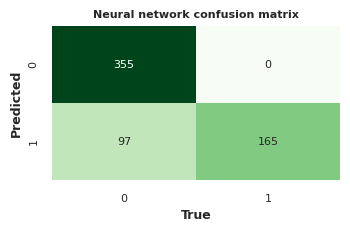

In [63]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False, fmt=".4g")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Neural network confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'NN_conf_matrix.pdf'), format='pdf')
plt.show()

In [64]:
net.model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               23200     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 43,602
Trainable params: 43,602
Non-trainable params: 0
_________________________________________________________________


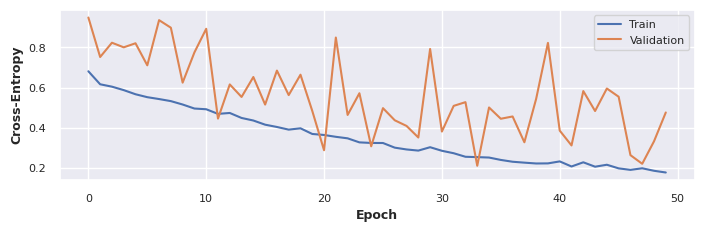

In [87]:
history = net.history_
fig, ax = plt.subplots(figsize=default_style.SHORT_FULLSIZE_FIGURE)
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.savefig(os.path.join(IMAGE_FOLDER, 'NN_Cross_entropy_class.pdf'), format='pdf')
plt.show()

20/20 [==============================] - 0s 3ms/step


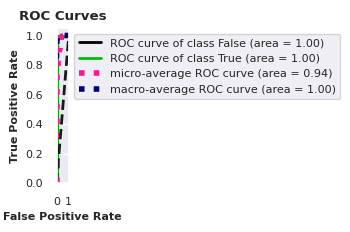

0.9957638963552307


In [66]:
from scikitplot.metrics import plot_roc

y_test_pred_proba = net.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'NN_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

# Ensemble methods

## Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [68]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-06-20 17:15:15,860] A new study created in memory with name: no-name-1597d81c-2c14-47e6-ae56-d2b24256419f
[I 2023-06-20 17:15:25,552] Trial 0 finished with value: 0.9302325581395349 and parameters: {'n_estimators': 550, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.9302325581395349.
[I 2023-06-20 17:15:28,691] Trial 4 finished with value: 0.9069767441860465 and parameters: {'n_estimators': 240, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 8, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9302325581395349.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as

[W 2023-06-20 17:16:01,638] Trial 15 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-06-20 17:16:06,840] Trial 13 finished with value: 0.9302325581395349 and parameters: {'n_estimators': 630, 'max_depth': 90, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.9302325581395349.
[W 2023-06-20 17:16:06,908] Trial 17 failed with parameters: {'n_estimators': 1830, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidPara

[W 2023-06-20 17:16:07,478] Trial 22 failed with value None.
[W 2023-06-20 17:16:07,585] Trial 23 failed with parameters: {'n_estimators': 1950, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-p

[W 2023-06-20 17:16:14,243] Trial 29 failed with value None.
[W 2023-06-20 17:16:14,384] Trial 30 failed with parameters: {'n_estimators': 1950, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-pa

[W 2023-06-20 17:16:18,527] Trial 36 failed with value None.
[W 2023-06-20 17:16:18,606] Trial 37 failed with parameters: {'n_estimators': 2000, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-pa

[W 2023-06-20 17:16:26,236] Trial 43 failed with value None.
[W 2023-06-20 17:16:26,340] Trial 44 failed with parameters: {'n_estimators': 1370, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/2573181156.py", line 16, in objective_fun
    rf.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-pa

[W 2023-06-20 17:16:26,893] Trial 49 failed with value None.
[I 2023-06-20 17:16:33,340] Trial 24 finished with value: 0.9069767441860465 and parameters: {'n_estimators': 1770, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.9302325581395349.
[I 2023-06-20 17:16:36,233] Trial 40 finished with value: 0.9069767441860465 and parameters: {'n_estimators': 1400, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.9302325581395349.
[I 2023-06-20 17:16:37,742] Trial 31 finished with value: 0.9302325581395349 and parameters: {'n_estimators': 1980, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 7, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.9302325581395349.


In [69]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(X_res_t, y_res_t)

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 550, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'gini'}
              precision    recall  f1-score   support

       False       0.95      0.99      0.97       355
        True       0.99      0.92      0.96       262

    accuracy                           0.96       617
   macro avg       0.97      0.96      0.96       617
weighted avg       0.97      0.96      0.96       617

Accuracy 0.9643435980551054
F1-score [0.96978022 0.95652174]


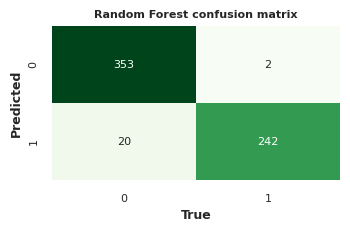

In [70]:
from sklearn.metrics import confusion_matrix

fig,ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', cbar=False, fmt=".4g")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Random Forest confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_conf_matrix.pdf'), format='pdf')
plt.show()

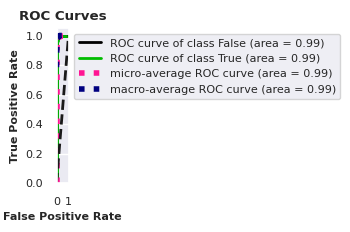

0.9921621331039673


In [71]:
from sklearn.metrics import roc_auc_score

y_test_pred_proba = rf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

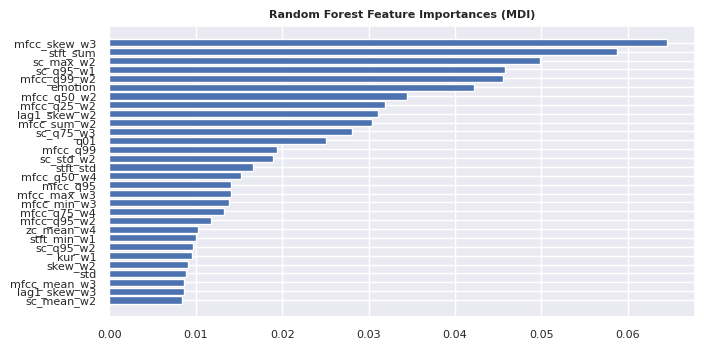

In [72]:
nbr_features = X_res_t.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots(figsize=default_style.FULLSIZE_FIGURE)
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1])
plt.title("Random Forest Feature Importances (MDI)")
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_importance.pdf'), format='pdf')
plt.show()

In [73]:
from sklearn.inspection import permutation_importance

In [74]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

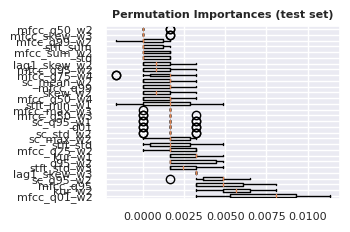

In [75]:
sorted_idx = result.importances_mean.argsort()[::-1][:30]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [76]:
from sklearn.tree import plot_tree

In [77]:
rf.estimators_[0]

DecisionTreeClassifier(max_depth=100, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, random_state=1376077109)

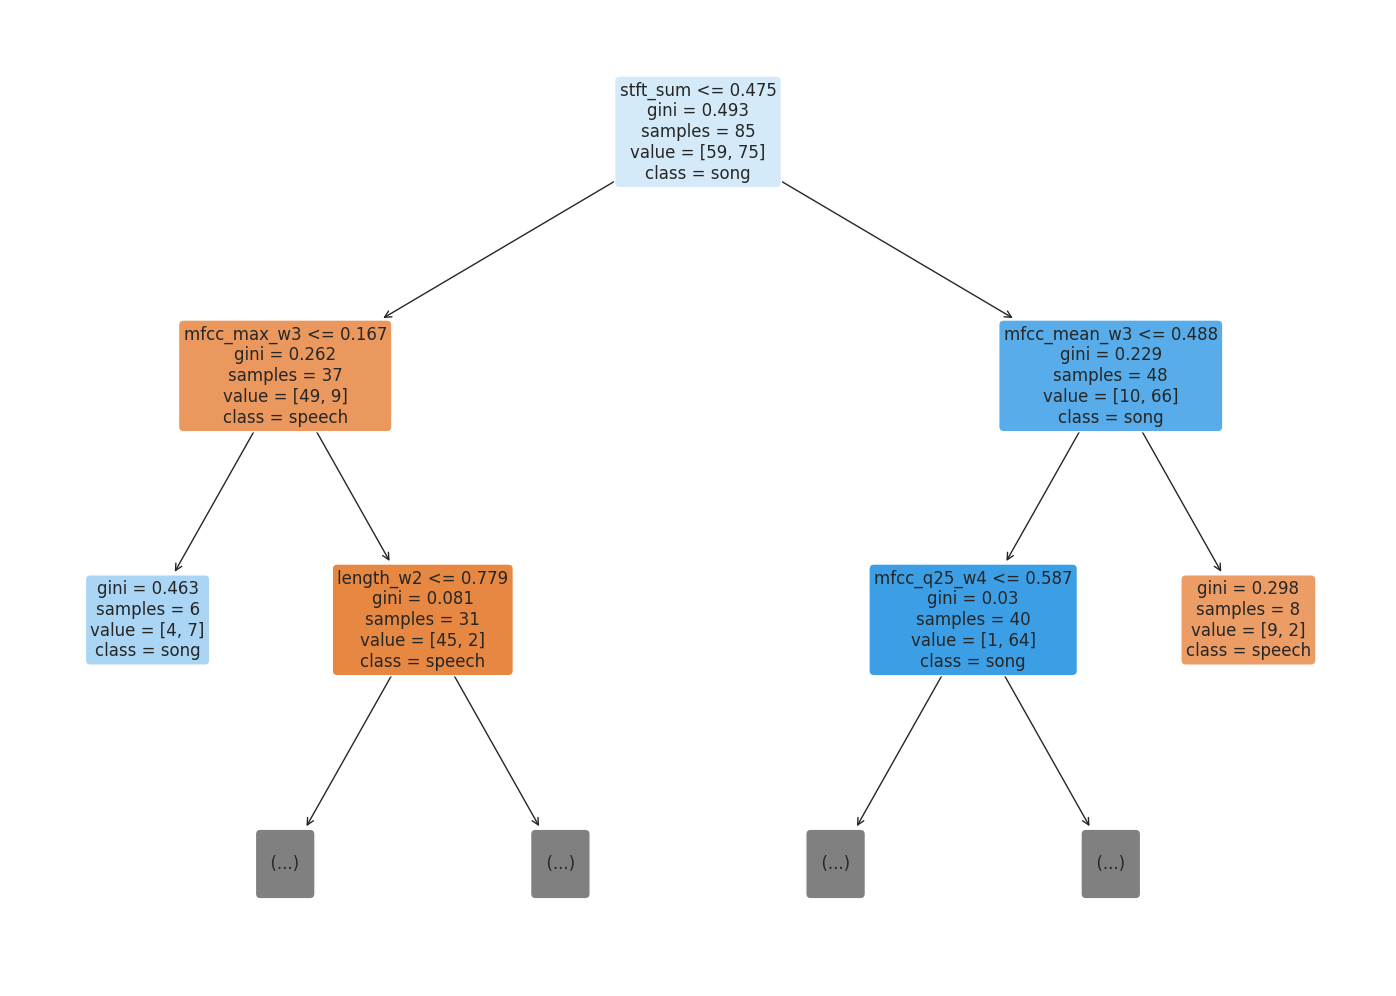

In [78]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.savefig(os.path.join(IMAGE_FOLDER, 'RanFor_trees.pdf'), format='pdf')
plt.show()

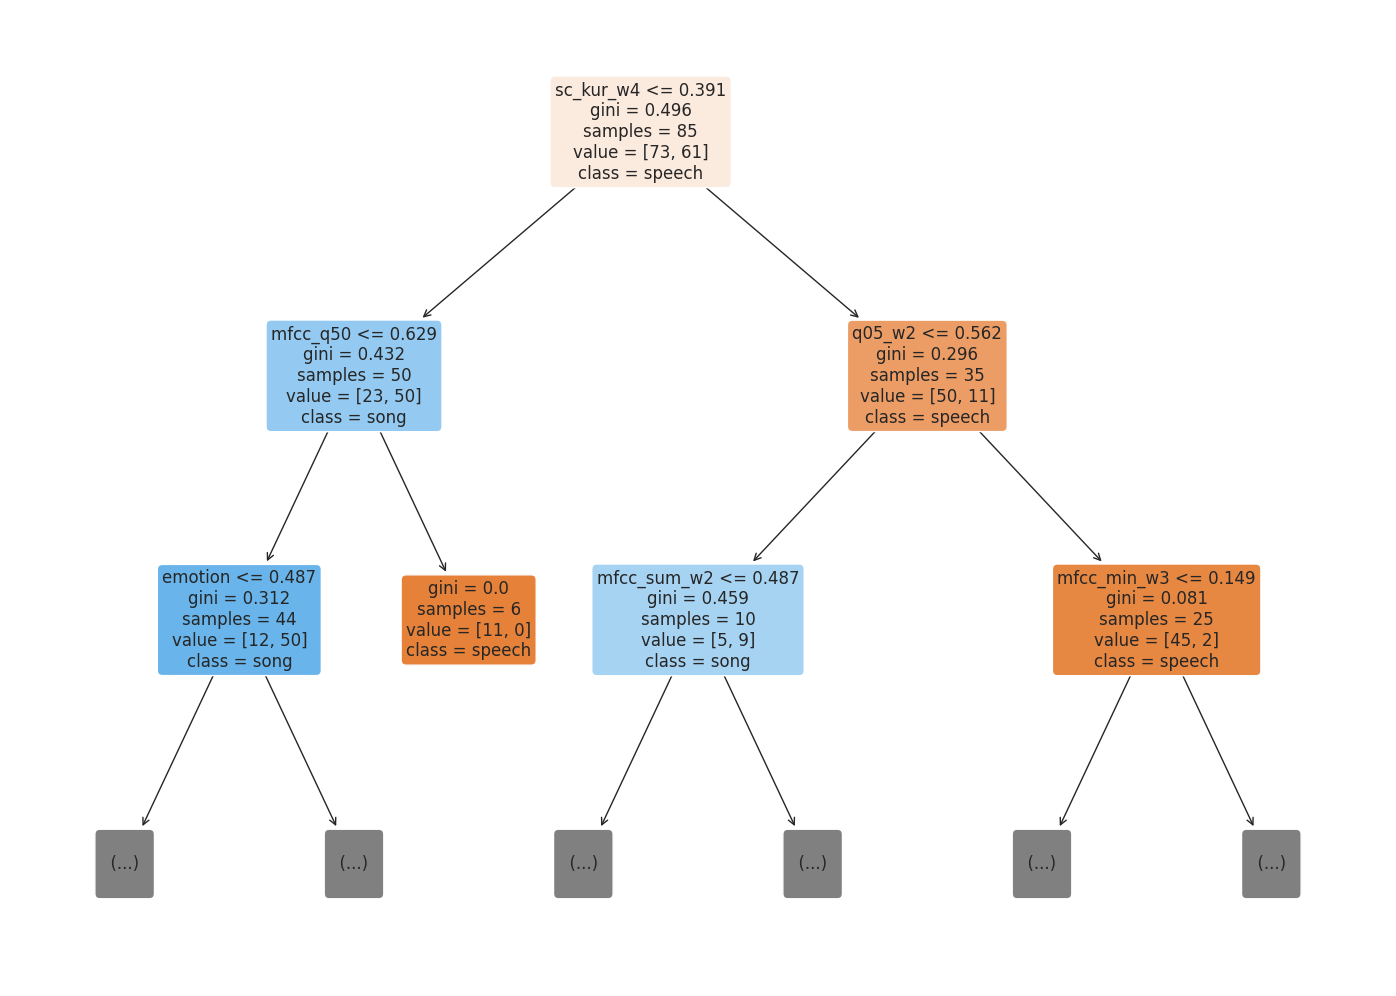

In [79]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [80]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [81]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_res_t, y_res_t)
    y_pred = rf.predict(X_res_v)
    error = accuracy_score(y_res_v, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 100, n_jobs = -1, catch=(ValueError,))

[I 2023-06-20 17:21:18,598] A new study created in memory with name: no-name-ebf5ab57-5403-4b70-a7da-ab62738592f5
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
[W 2023-06-20 17:21:18,701] Trial 3 failed with parameters: {'n_estimators': 14, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 8, 'learning_rate': 0.29603407665750514, 'criterion': 'mae', 'subsample': 0.5005421393911044, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-package

[W 2023-06-20 17:21:20,040] Trial 11 failed with value None.
[I 2023-06-20 17:21:20,014] Trial 2 finished with value: 0.9069767441860465 and parameters: {'n_estimators': 13, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 7, 'learning_rate': 0.21234403184068523, 'criterion': 'friedman_mse', 'subsample': 0.5270611029473914, 'loss': 'log_loss'}. Best is trial 1 with value: 0.9069767441860465.
[W 2023-06-20 17:21:20,059] Trial 12 failed with parameters: {'n_estimators': 19, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 7, 'learning_rate': 0.21218156808278624, 'criterion': 'friedman_mse', 'subsample': 0.6387689259076357, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'min_samples_split' parameter of GradientBoostingClassifier must be an int in the range [2, inf) or a float in the range (0.0, 1.0]. Got 1 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/s

[W 2023-06-20 17:21:21,110] Trial 20 failed with value None.
[W 2023-06-20 17:21:21,163] Trial 21 failed with parameters: {'n_estimators': 17, 'max_depth': 80, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 10, 'learning_rate': 0.050981406651974974, 'criterion': 'mae', 'subsample': 0.962772730280088, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-06-20 17:21:22,313] Trial 27 failed with value None.
[W 2023-06-20 17:21:22,493] Trial 28 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 4, 'learning_rate': 0.28367943960838854, 'criterion': 'mae', 'subsample': 0.7120326525886576, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
 

[W 2023-06-20 17:21:23,332] Trial 33 failed with value None.
[W 2023-06-20 17:21:23,328] Trial 34 failed with value None.
[W 2023-06-20 17:21:23,321] Trial 32 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 4, 'learning_rate': 0.2768523993185142, 'criterion': 'mae', 'subsample': 0.7021642745554879, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ense

[W 2023-06-20 17:21:23,819] Trial 37 failed with value None.
[W 2023-06-20 17:21:24,029] Trial 39 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 10, 'learning_rate': 0.27002057563348636, 'criterion': 'mae', 'subsample': 0.7342941618816264, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
 

[W 2023-06-20 17:21:24,450] Trial 44 failed with value None.
[W 2023-06-20 17:21:24,573] Trial 45 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 4, 'learning_rate': 0.26384250907631623, 'criterion': 'mae', 'subsample': 0.7204036734352753, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  

[W 2023-06-20 17:21:25,284] Trial 53 failed with value None.
[W 2023-06-20 17:21:25,278] Trial 50 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 10, 'learning_rate': 0.26975944562031473, 'criterion': 'mae', 'subsample': 0.7332347982231483, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
 

[W 2023-06-20 17:21:25,815] Trial 55 failed with value None.
[W 2023-06-20 17:21:25,791] Trial 57 failed with value None.
[W 2023-06-20 17:21:25,819] Trial 58 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 10, 'learning_rate': 0.27079251411366184, 'criterion': 'mae', 'subsample': 0.7186296004606768, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ens

[W 2023-06-20 17:21:26,577] Trial 61 failed with value None.
[W 2023-06-20 17:21:26,558] Trial 64 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 10, 'learning_rate': 0.2788602915031633, 'criterion': 'mae', 'subsample': 0.7273611900932268, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  

[W 2023-06-20 17:21:27,006] Trial 65 failed with value None.
[W 2023-06-20 17:21:27,019] Trial 68 failed with value None.
[W 2023-06-20 17:21:27,298] Trial 70 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 10, 'learning_rate': 0.26483876086365243, 'criterion': 'mae', 'subsample': 0.7182678307327393, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ens

[W 2023-06-20 17:21:27,753] Trial 76 failed with value None.
[W 2023-06-20 17:21:27,736] Trial 73 failed with value None.
[W 2023-06-20 17:21:27,722] Trial 74 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 10, 'learning_rate': 0.27038279070739146, 'criterion': 'mae', 'subsample': 0.7267079652445867, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ens

[W 2023-06-20 17:21:28,240] Trial 78 failed with value None.
[W 2023-06-20 17:21:28,294] Trial 80 failed with value None.
[W 2023-06-20 17:21:28,606] Trial 84 failed with parameters: {'n_estimators': 6, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 10, 'learning_rate': 0.2700542017732301, 'criterion': 'mae', 'subsample': 0.7381792077844502, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ense

[W 2023-06-20 17:21:29,070] Trial 85 failed with value None.
[W 2023-06-20 17:21:29,048] Trial 88 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 10, 'learning_rate': 0.2629438734962466, 'criterion': 'mae', 'subsample': 0.7169868114672703, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
 

[W 2023-06-20 17:21:29,526] Trial 90 failed with value None.
[W 2023-06-20 17:21:29,513] Trial 92 failed with value None.
[W 2023-06-20 17:21:29,798] Trial 93 failed with parameters: {'n_estimators': 5, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 10, 'learning_rate': 0.27103140597009506, 'criterion': 'mae', 'subsample': 0.7269672535193683, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ens

[W 2023-06-20 17:21:30,245] Trial 97 failed with parameters: {'n_estimators': 6, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 10, 'learning_rate': 0.27449204457989745, 'criterion': 'mae', 'subsample': 0.6997197344582593, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'squared_error', 'friedman_mse'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_83302/3961920590.py", line 17, in objective_fun
    gb.fit(X_res_t, y_res_t)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/li

In [82]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(X_res_t, y_res_t)

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 5, 'max_depth': 30, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 6, 'learning_rate': 0.18261924639876898, 'criterion': 'friedman_mse', 'subsample': 0.7099391065745213, 'loss': 'exponential'}
              precision    recall  f1-score   support

       False       0.83      0.99      0.90       355
        True       0.98      0.73      0.84       262

    accuracy                           0.88       617
   macro avg       0.91      0.86      0.87       617
weighted avg       0.90      0.88      0.88       617

Accuracy 0.880064829821718
F1-score [0.90463918 0.83842795]


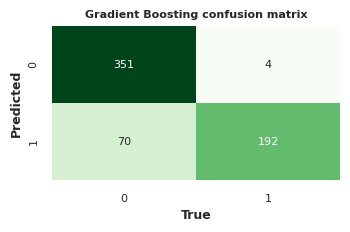

In [88]:
from sklearn.metrics import confusion_matrix

fig,ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

cf = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf, annot=True, cmap='Greens', fmt=".4g", cbar=False)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Gradient Boosting confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'GB_conf_matrix.pdf'), format='pdf')
plt.show()

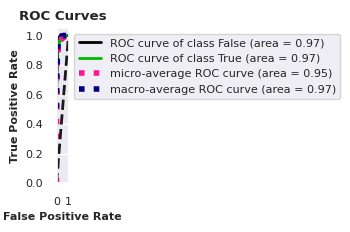

0.9699494677991614


In [84]:
y_test_pred_proba = gb.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'GB_ROC.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))